In [94]:
%pylab inline
import json
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
import sklearn
import pandas as pd
from typing import Tuple
from typing import List
import numpy as np

# dataset1 = pd.read_csv('data_till_29_oct.csv')
# dataset2 = pd.read_csv('data_after_29_oct.csv')
# # convert to arrays from strings
# def assign_task_name(string):
#     if 'lumosity'in string:
#         return 'cognitive'
#     if 'Game' in string:
#         return 'cognitive'
#     if 'head'in string:
#         return 'baseline'
#     if 'nback' in string:
#         return 'cognitive'
#     if 'Baseline' in string:
#         return'baseline'
#     else:
#         return 'cognitive'

# dataset=dataset1.append(dataset2)
# dataset.eeg = dataset.eeg.map(json.loads)
# dataset['date']=dataset['date'].apply(lambda x:x+'-2017')
# dataset['task']=dataset['activity'].apply(lambda x :assign_task_name(x))
# dataset.to_csv('all_data_labelled.csv',index=False)
# dataset['date']=pd.to_datetime(dataset['date'], format='%d-%m-%Y')
# dataset.to_csv('all_data_labelled.csv',index=False)

Populating the interactive namespace from numpy and matplotlib


/Users/sanaiqbal/anaconda/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['partition']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [95]:
dataset = pd.read_csv('all_data_labelled.csv')
dataset.eeg = dataset.eeg.map(json.loads)
dataset['date']=pd.to_datetime(dataset['date'])

dataset=dataset.sort_values(by='date')


# add phase info


In [96]:
def get_phase(date):
    date1 = datetime.datetime.strptime('2017-10-10', "%Y-%m-%d")
    days=(date-date1).days
    
    if days<0:
        days=30+days
    if days>30:
        days=days-30
        
    return days

dataset['phase_distance']=dataset['date'].apply(lambda x:get_phase(x))
dataset['phase_no']=pd.cut(dataset['phase_distance'],bins=[-1,5,14,15,31],labels=[1,2,3,4])

In [97]:
lengths_of_eeg=dataset['eeg'].apply(lambda x:len(x))

rm=[i for i, j in enumerate(lengths_of_eeg) if j == 0]
dataset=dataset.drop(dataset.index[[rm]])
# min(lengths_of_eeg)

In [98]:
lengths_of_eeg=dataset['eeg'].apply(lambda x:len(x))
min(lengths_of_eeg)

# rm=[i for i, j in enumerate(lengths_of_eeg) if j == 0]
# rm

1180

In [99]:
# dataset['phase_distance']

In [100]:
# # drop any eeg of len 0
# dataset=dataset.drop(dataset.index[[rm]])
# lengths_of_eeg=dataset['eeg'].apply(lambda x:len(x))
# min(lengths_of_eeg)


In [101]:

def partition(lst, size):
    
    """split eeg list into partitions of size 'size"""
    
    if len(lst)<size:
        return []
    else:
        lists=[]

        for i  in range(0, len(lst), size):
            if len(lst[i:i+size])==size:
                lists.append(lst[i:i+size])

        return lists
    
    
from numpy import dot
from numpy.linalg import norm

def cosine_similarity(a,b):
    return dot(a, b)/(norm(a)*norm(b))
                      
partition([1,2,3,4,5,6,7,8,9,10],9)      


[[1, 2, 3, 4, 5, 6, 7, 8, 9]]

In [102]:
# partition each  eeg entry into equal length lists
dataset['eeg']=dataset['eeg'].apply(lambda x:partition(x,1024))

In [103]:
#dataset['eeg'].apply(lambda x:len(x))

In [104]:
def to_power_spectrum (raw_readings):
    '''
    Take raw voltages,
    transform into frequency domain,
    return a power spectrum.
    
    '''
    
    sampling_rate=len(raw_readings)
    # FFT the raw readings
    fftd = np.fft.fft(raw_readings)
    # take absolute value
    # producing a symmetrical power spectrum
    ps = np.abs(fftd)**2
    # since the power spectrum is symmetrical, 
    # take half
    half_len = len(ps)//2
    ps = ps[:half_len]
#     # we'll calculate the frequencies
    window_size = len(raw_readings)
    freqs = numpy.fft.fftfreq(window_size,d=1/sampling_rate)
#     # splitting that in half to match
    freqs = freqs[:half_len]
    power_spectrum = pd.DataFrame({
        'frequency (Hz)': freqs,
        'magnitude': ps,
    })
    return power_spectrum
def bandpass (
    power_spec: pd.Series,
    low_cutoff: float,
    high_cutoff: float,)-> pd.Series:
    
    '''"zooming in" or "cropping" to these frequencies.'''
    
    return power_spec[(power_spec['frequency (Hz)'] > low_cutoff) & 
                      (power_spec['frequency (Hz)'] < high_cutoff)]


In [107]:
def pickup_randomchunk(raw_reading_chunks):
    '''this function picks a random chunk from the partitioned signal'''
    index = np.random.randint(len(raw_reading_chunks))
#     print(raw_reading_chunks [index])
    return raw_reading_chunks [index] 


def plot_eeg(group,date):
    colormap=['red','green','black','blue','aqua','pink']
    tasklist={'cognitive':'red','baseline':'blue'}
    counter=0
    plt.figure(figsize=(20,5),dpi=150)
    for i, row in group.iterrows():
#         print(row['eeg'])
#         print(i)
        plt.plot(row['eeg'][1], linestyle='-',linewidth = 1,color= tasklist[row['task']])
        counter+=1
    plt.title('RAW-EEG for'+date)
    plt.legend()
    plt.show()
        
        
        
def plot_fft_eeg(group,date):
    colormap=['red','green','black','blue','aqua','pink']
    tasklist={'cognitive':1,'baseline':2}
    tasklist={'cognitive':'red','baseline':'blue'}
    counter=0
    plt.figure(figsize=(20,5),dpi=150)
    plt.axvline(x=0.5,linewidth = 1.5)
    plt.text(0.5,0,'delta',rotation=90)
    plt.axvline(x=4,linewidth = 1.5)
    plt.text(4,1,'theta',rotation=90)
    plt.axvline(x=8,linewidth = 1.5)
    plt.text(8,1,'alpha',rotation=90)
    plt.axvline(x=13,linewidth = 1.5)
    plt.text(13,1,'beta',rotation=90)
    plt.axvline(x=30,linewidth = 1.5)
    plt.text(30,1,'gamma',rotation=90)
   
    for i, row in group.iterrows():
        if len(row['eeg'])>0:
# put condition to get second list of each eeg -inserting 1 in >>>row['eeg'][1]
        
            power_spec=to_power_spectrum(pickup_randomchunk(row['eeg']))
       
            plt.plot(bandpass(power_spec,0,30),color=tasklist[row['task']],linewidth = 1.5, label=row['task'])
        counter+=1
    plt.title(' FFT PLOT for'+ str(date))
    plt.legend()
    plt.show()
        

Date 2017-10-08 00:00:00


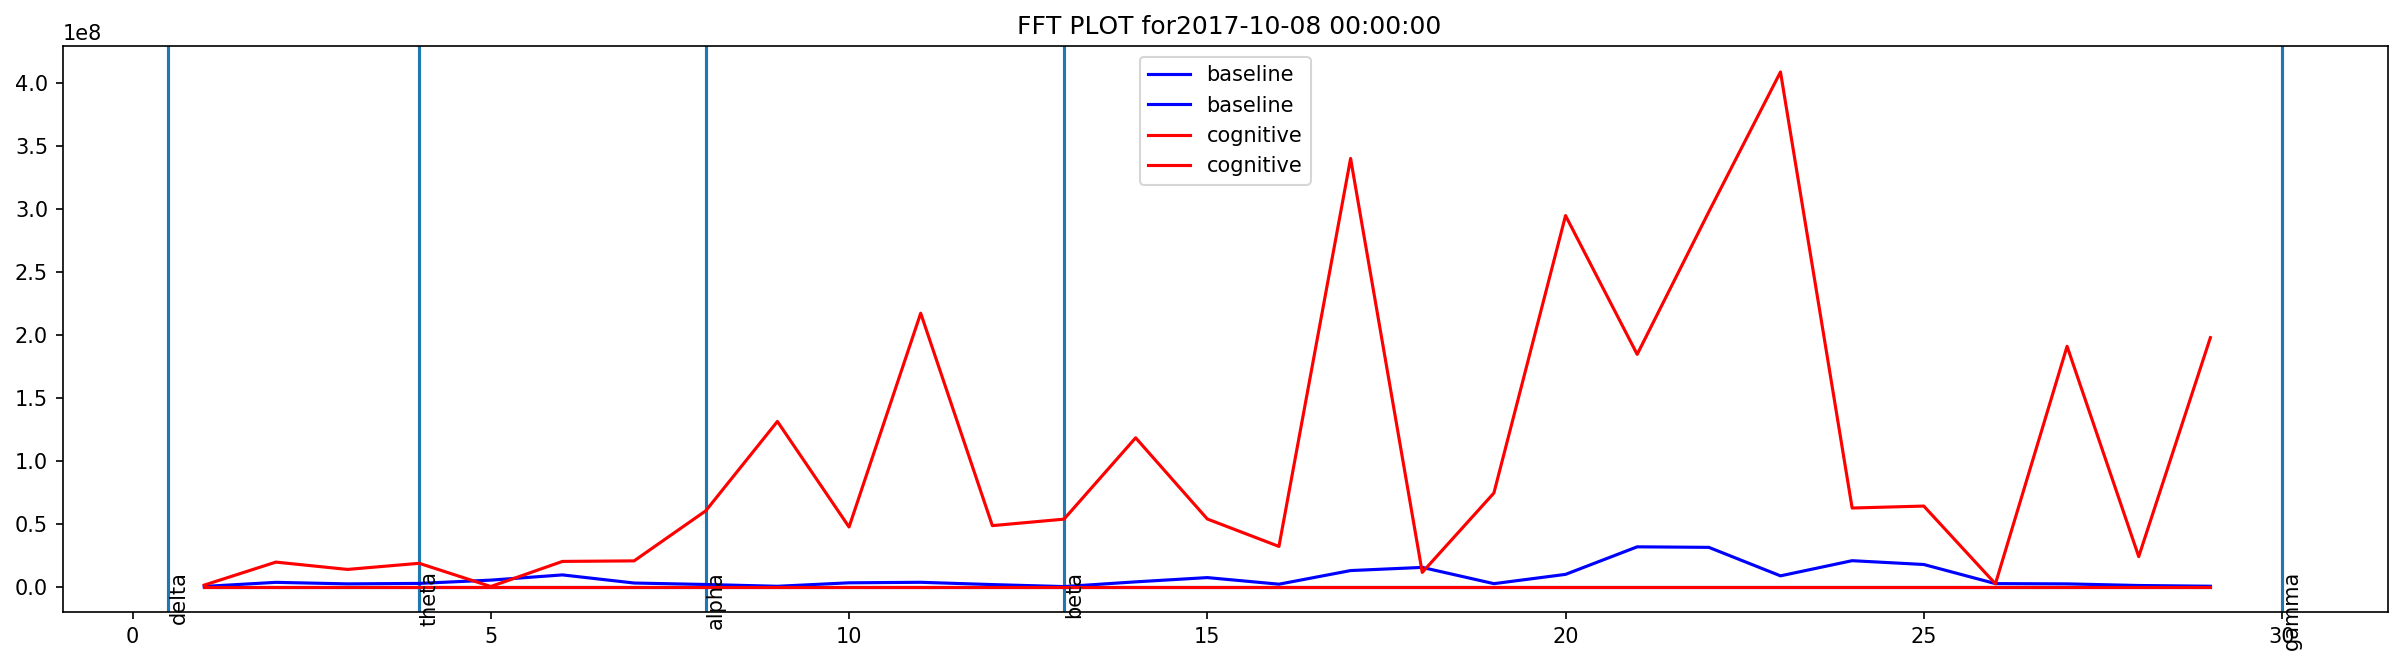

Date 2017-10-09 00:00:00


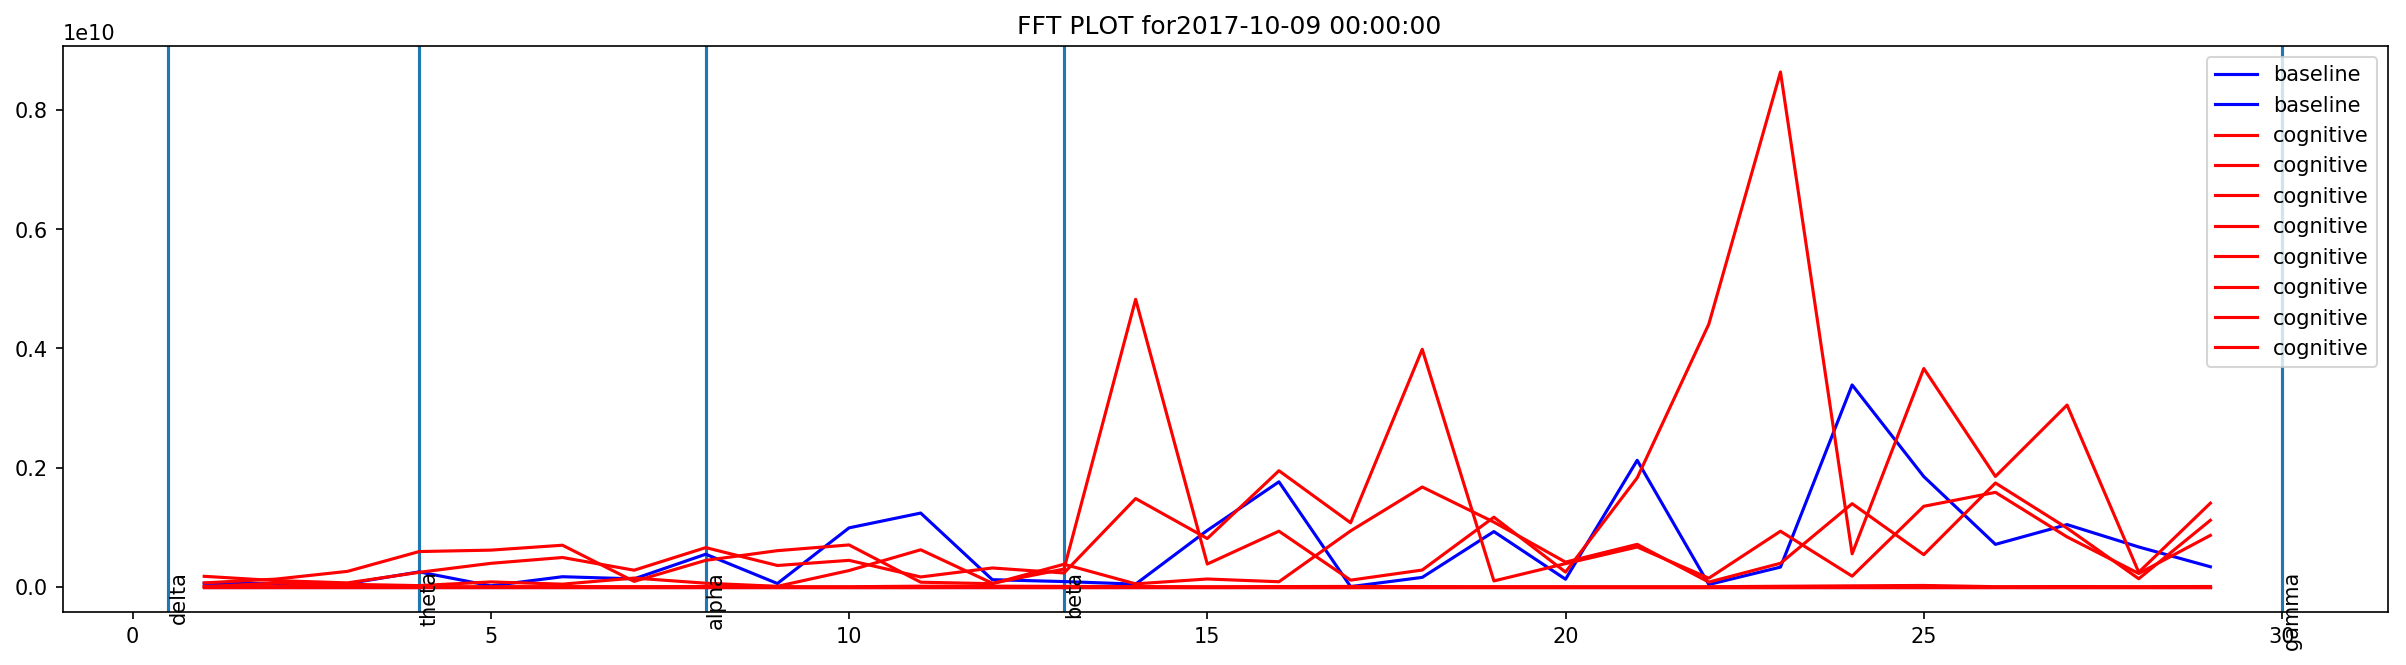

Date 2017-10-10 00:00:00


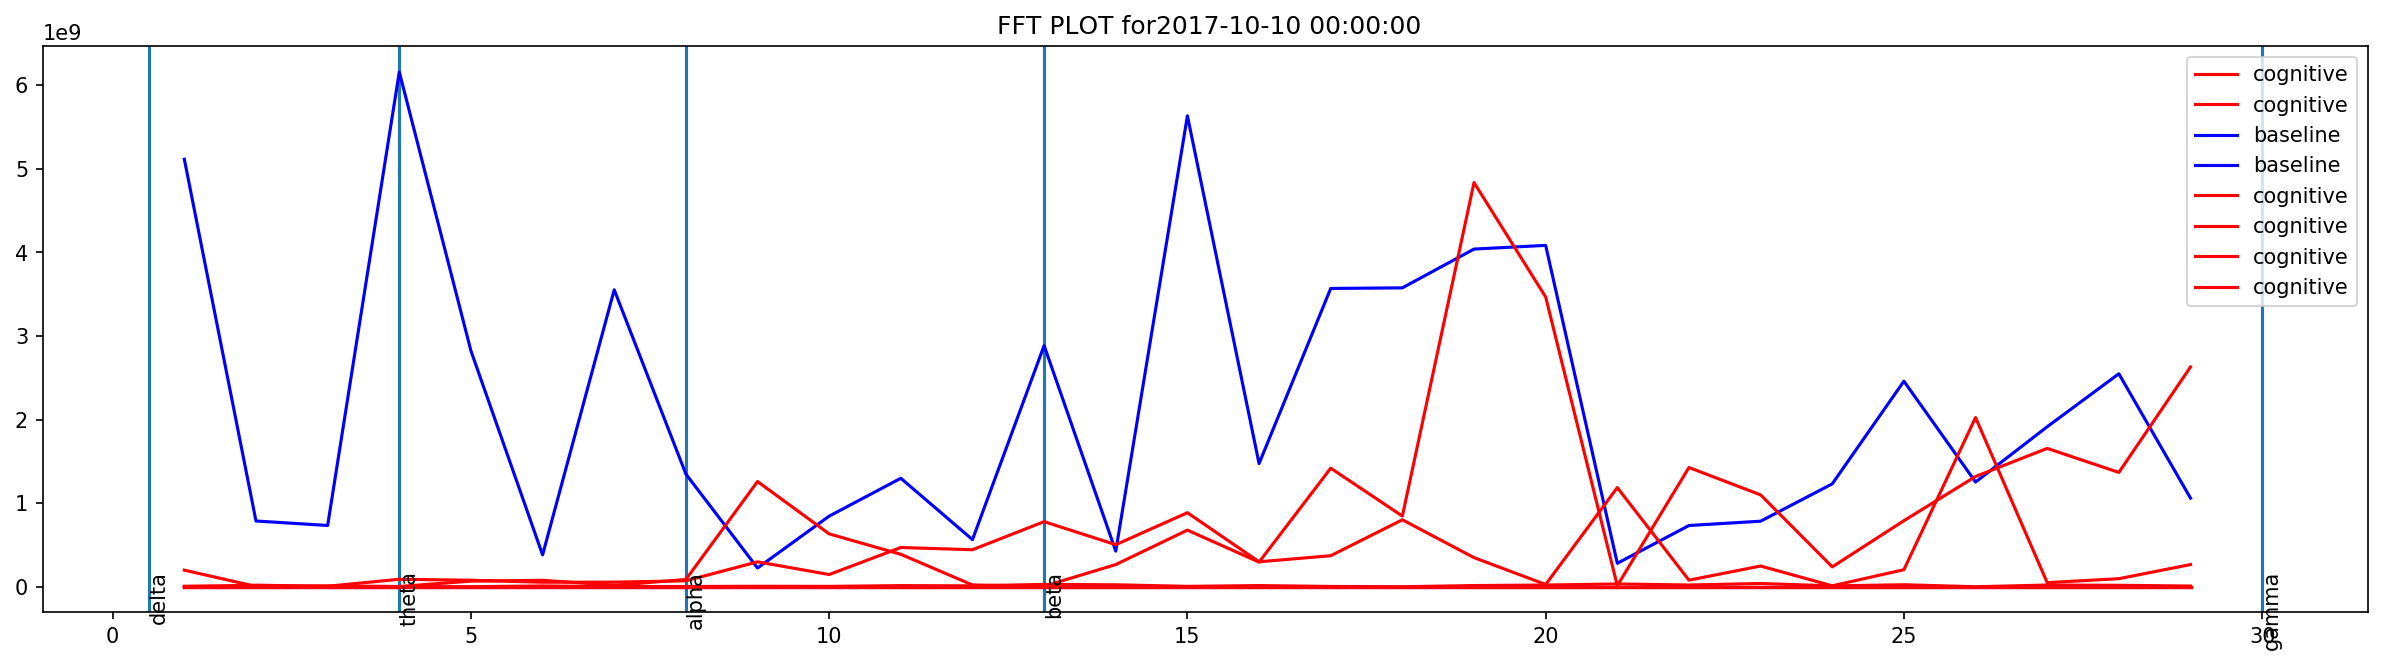

Date 2017-10-11 00:00:00


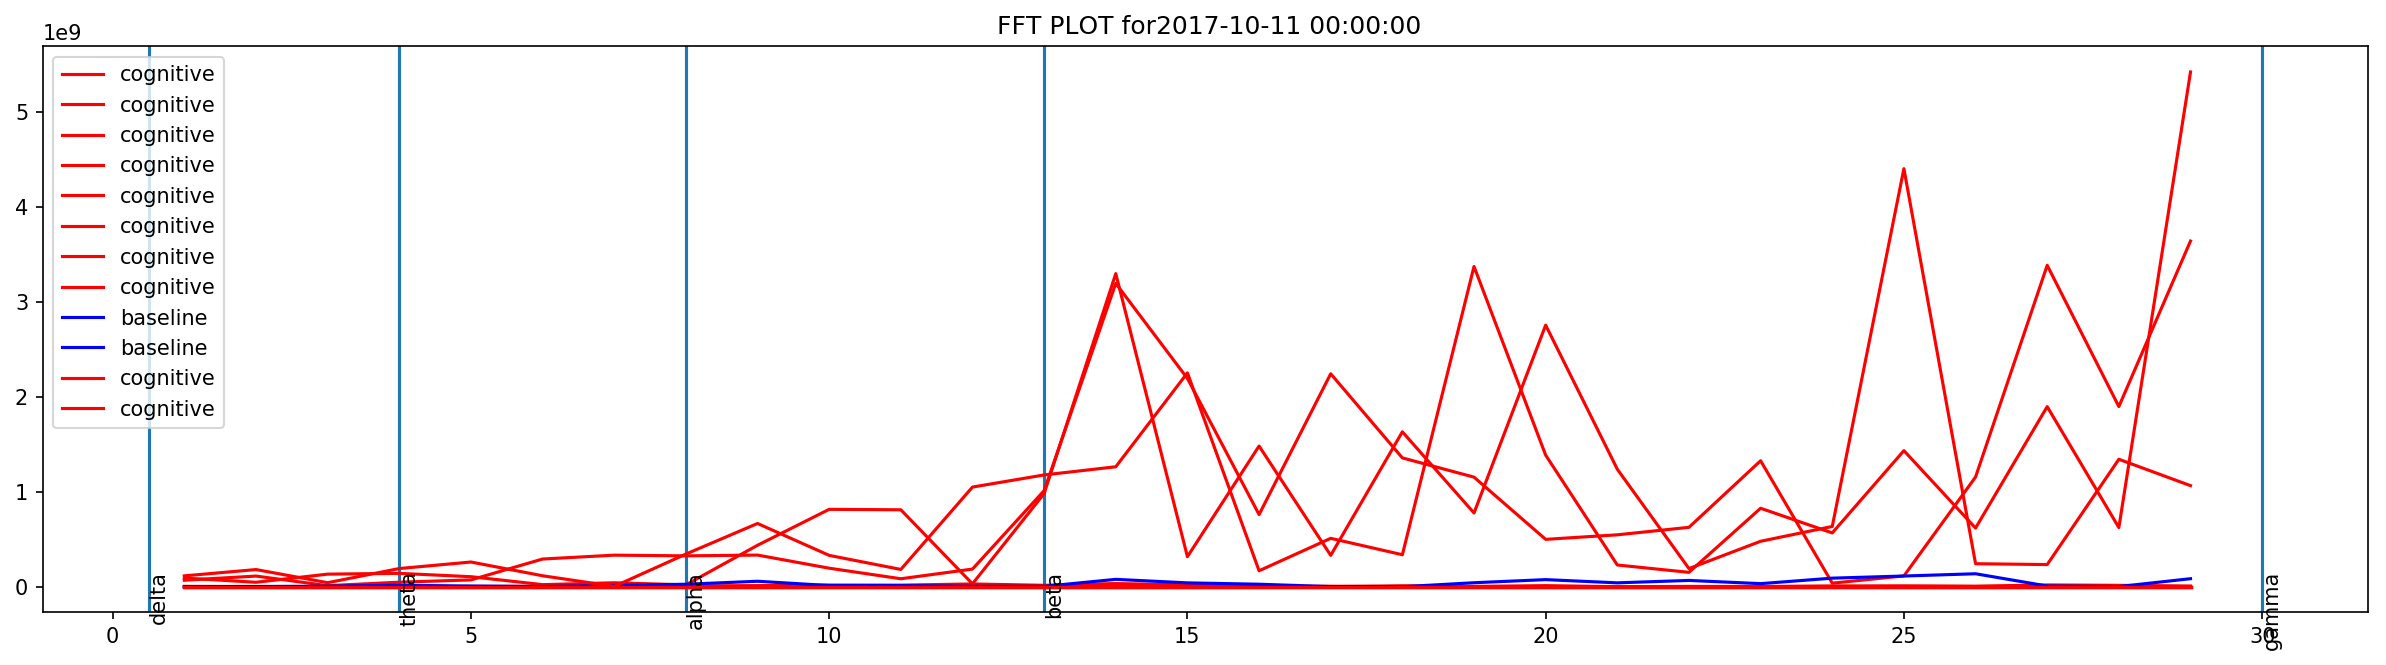

Date 2017-10-12 00:00:00


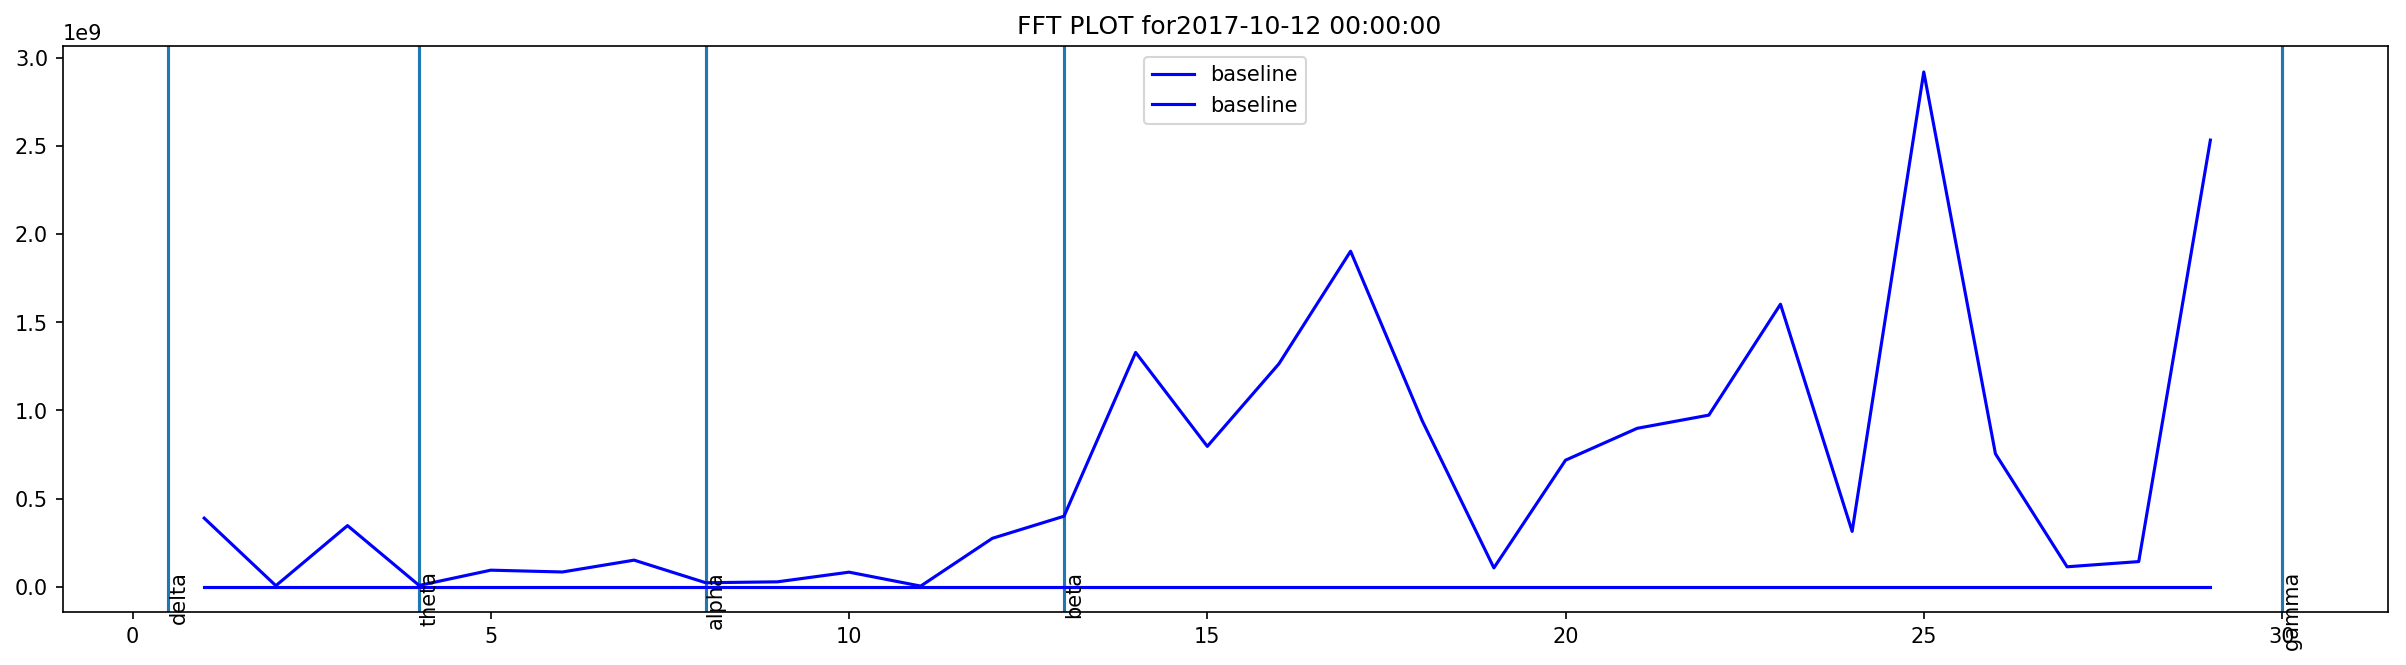

Date 2017-10-13 00:00:00


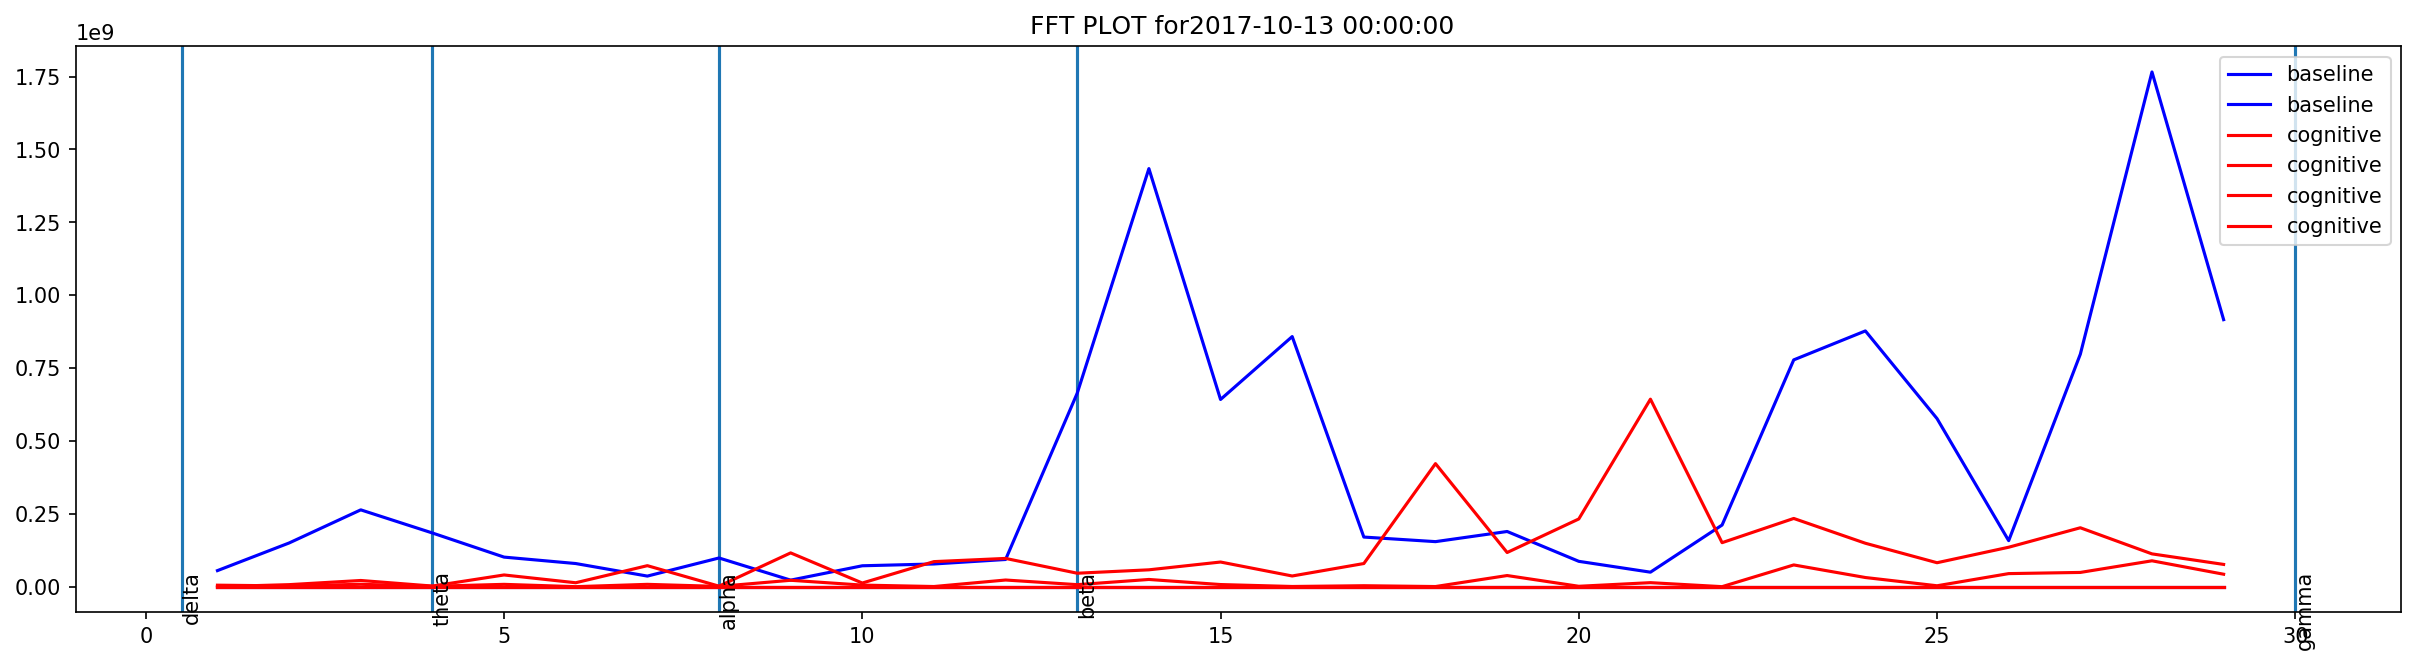

Date 2017-10-16 00:00:00


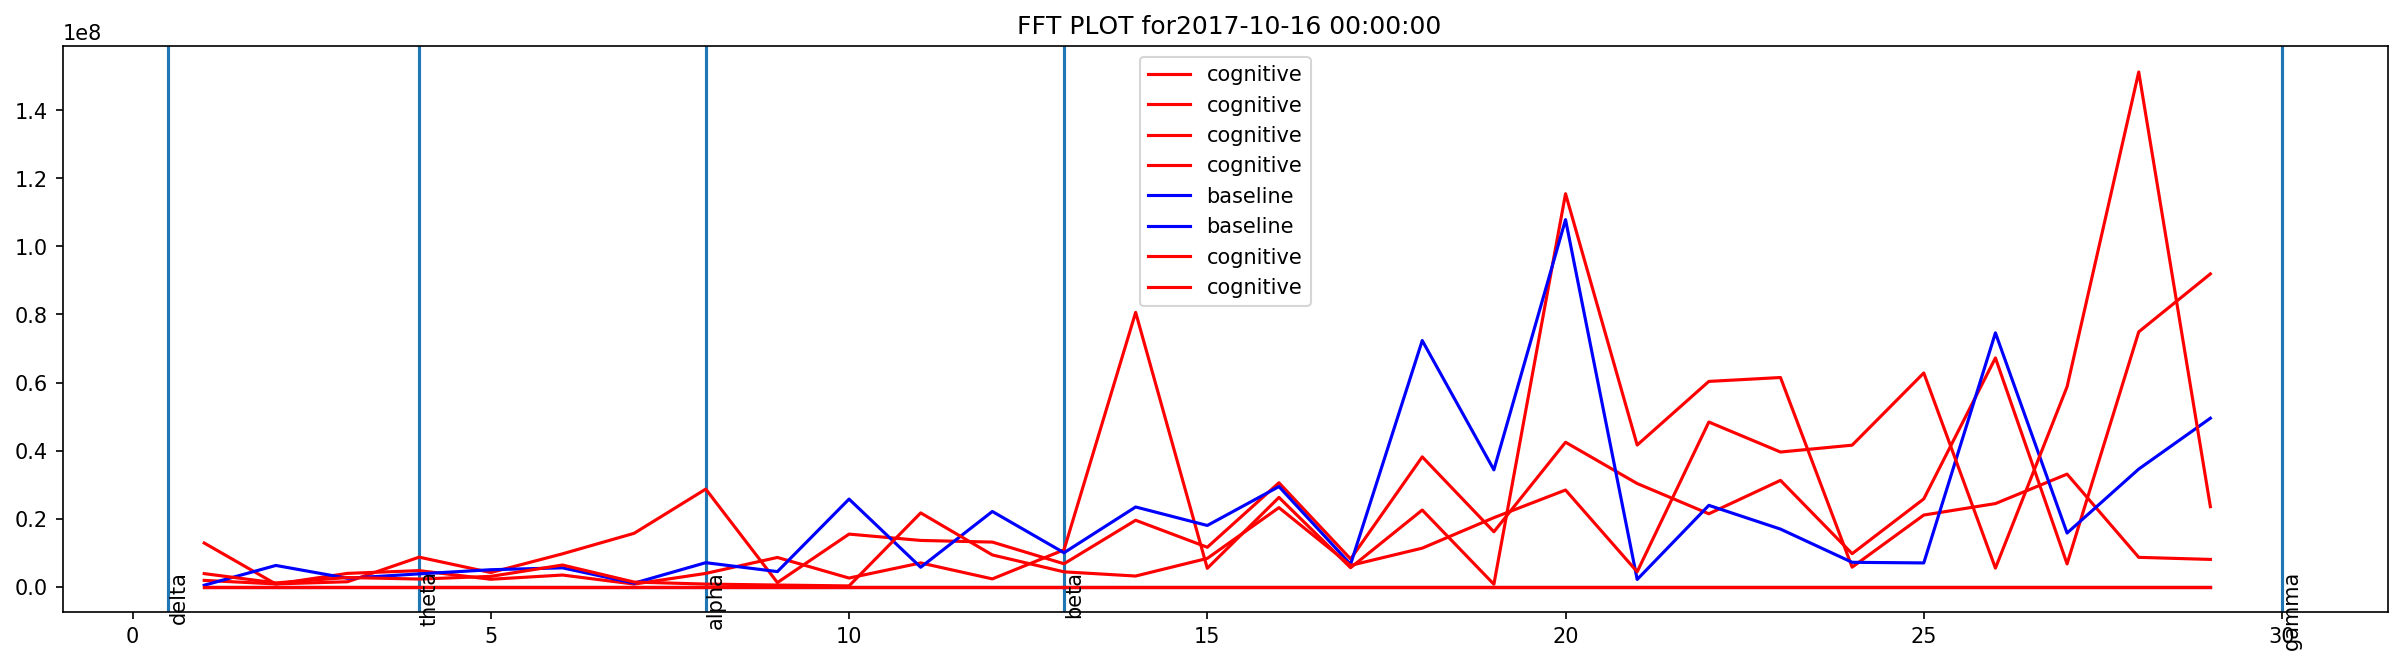

Date 2017-10-18 00:00:00


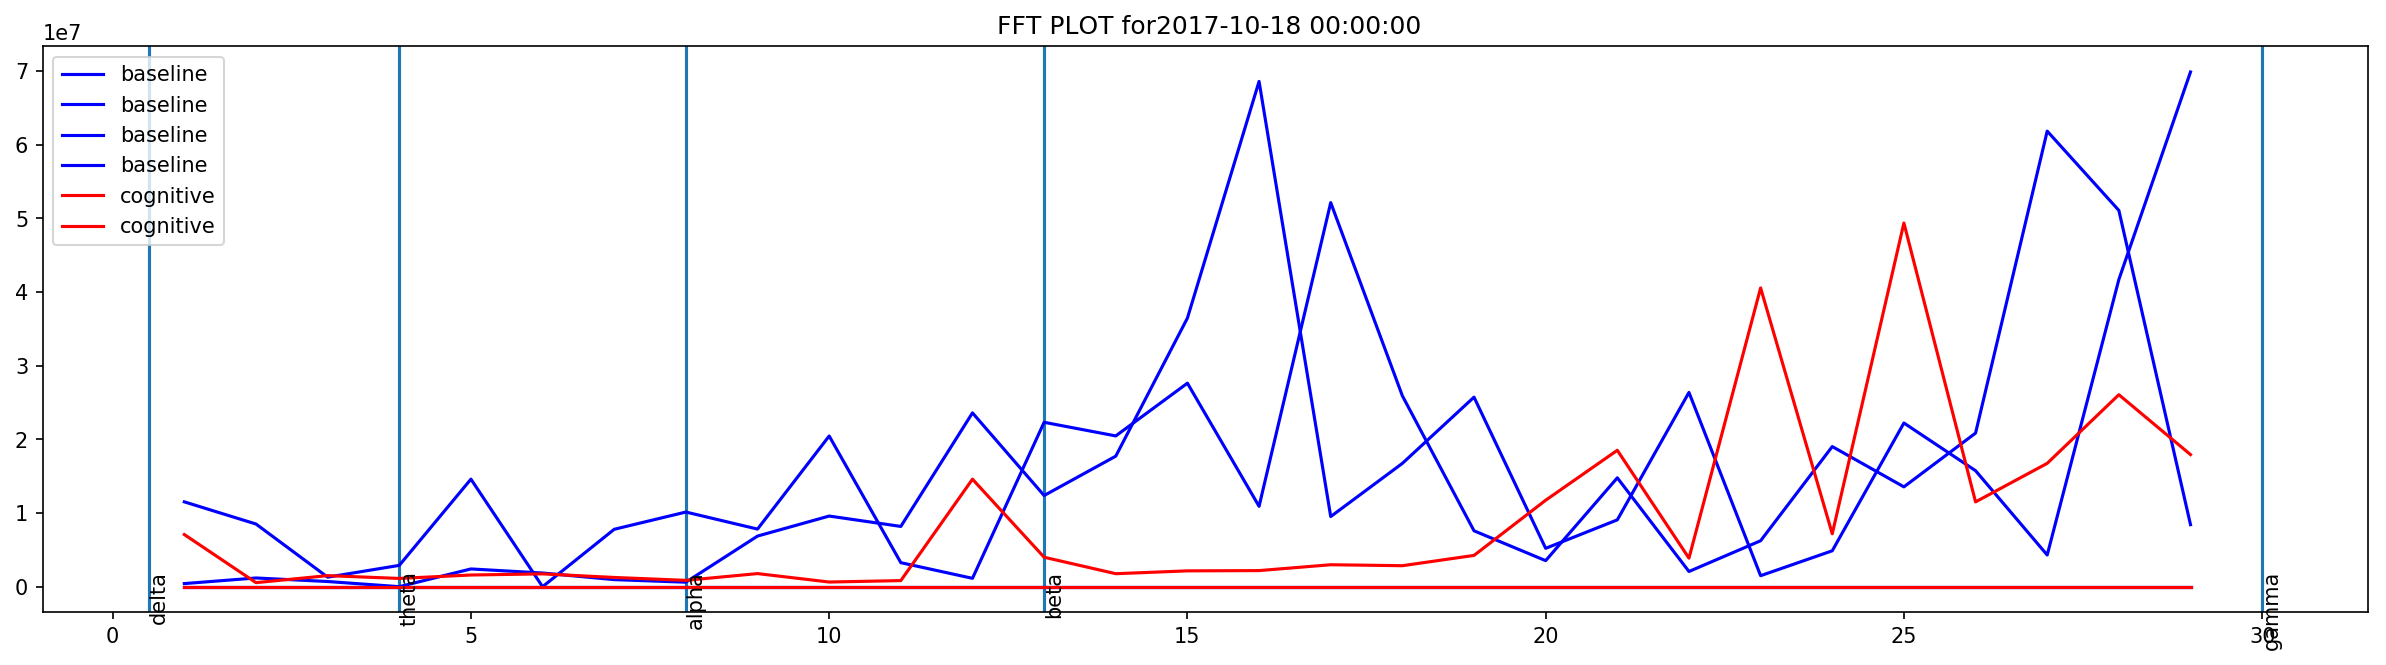

Date 2017-10-20 00:00:00


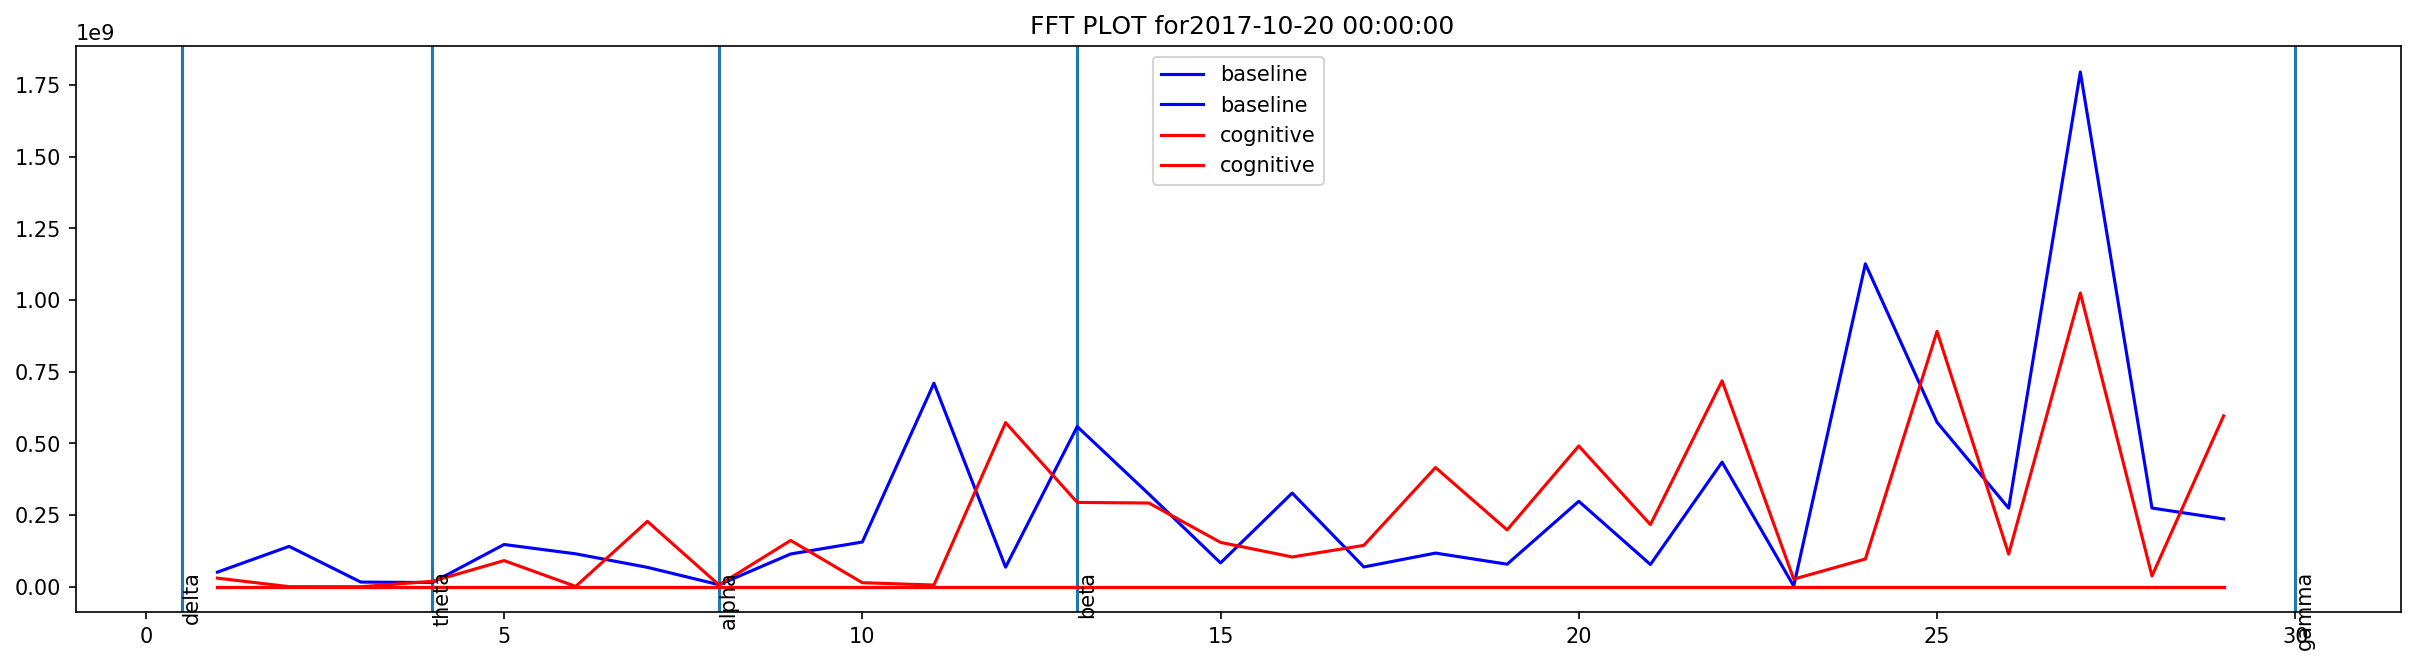

Date 2017-10-22 00:00:00


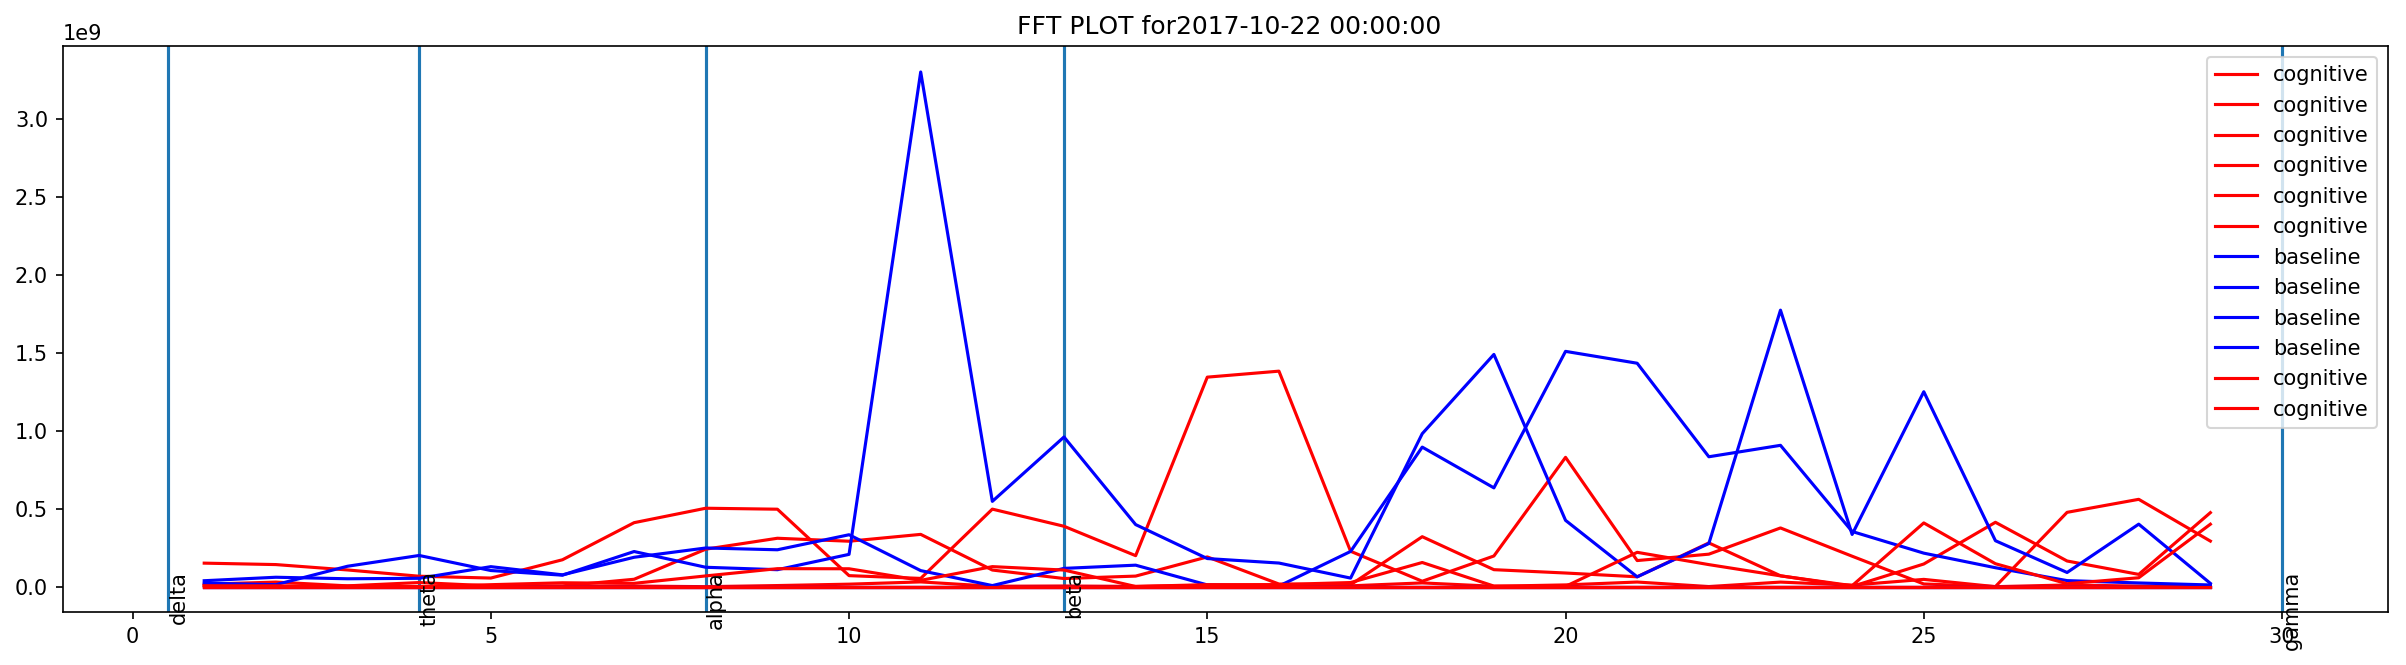

Date 2017-10-23 00:00:00


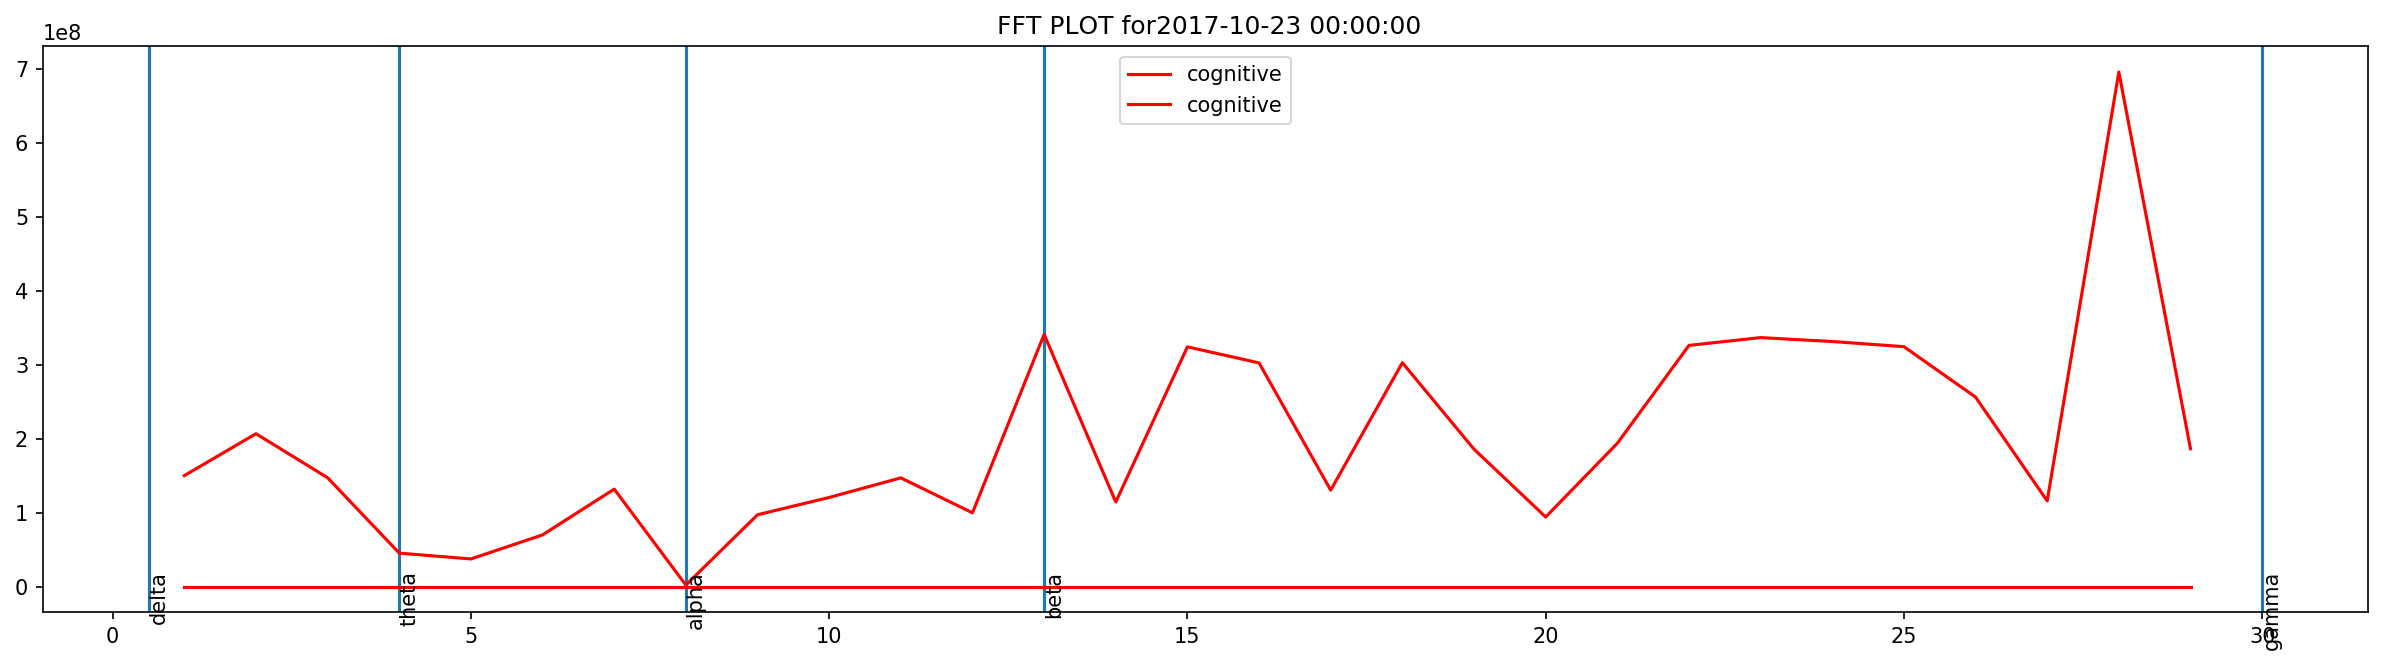

Date 2017-10-24 00:00:00


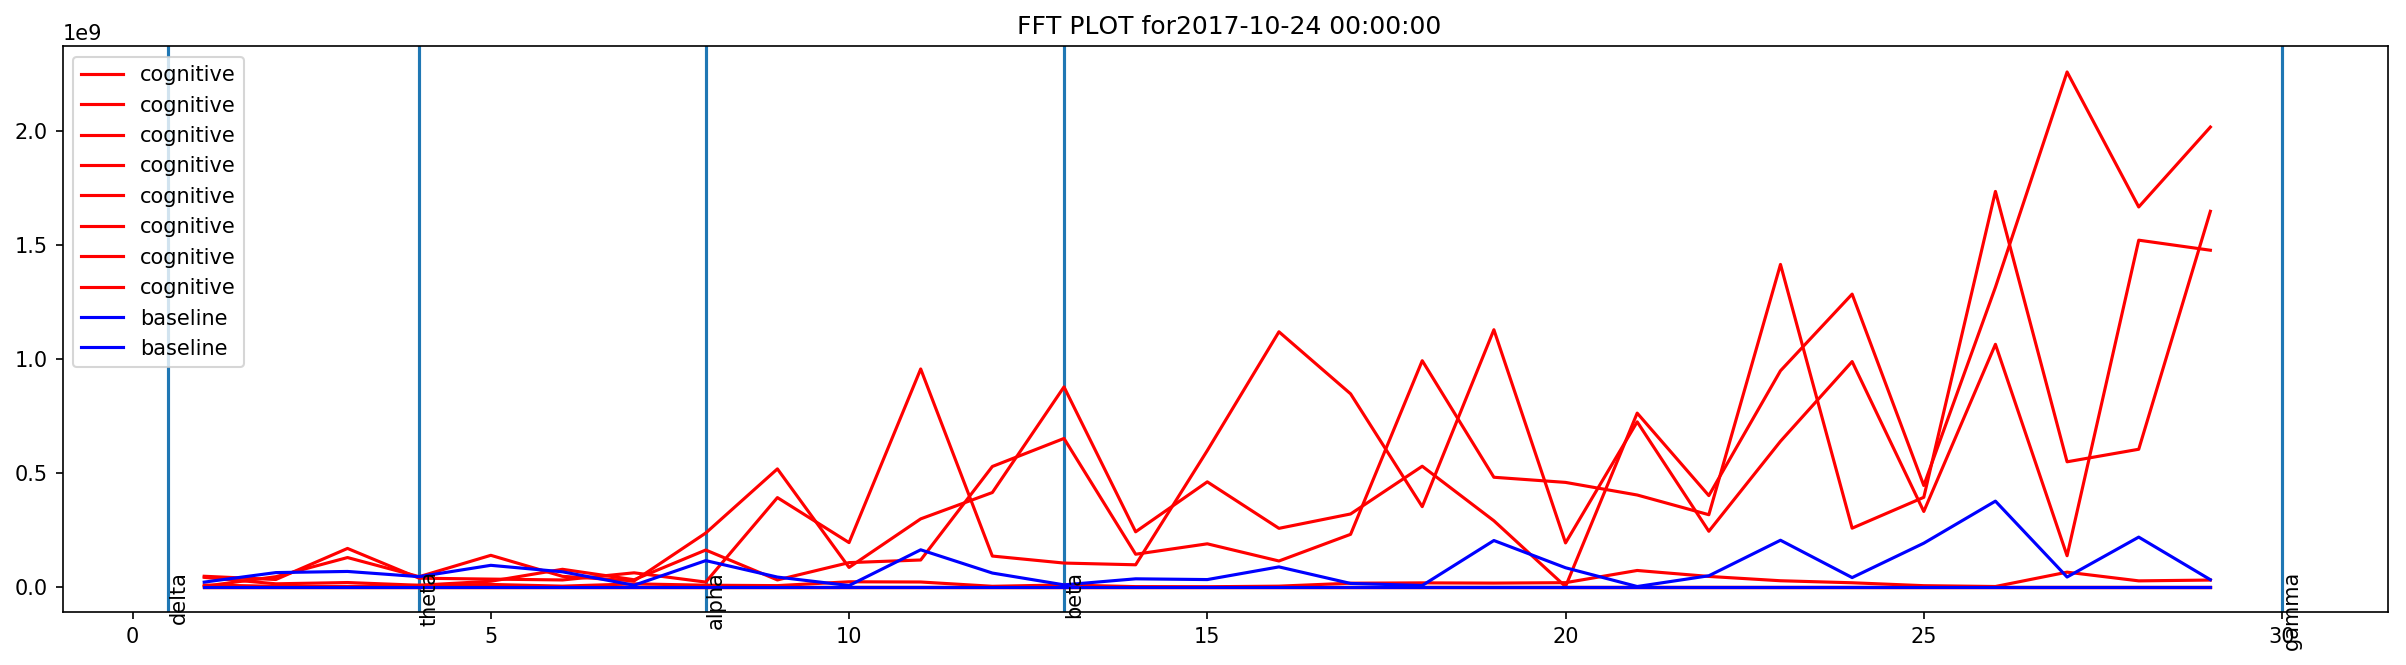

Date 2017-10-27 00:00:00


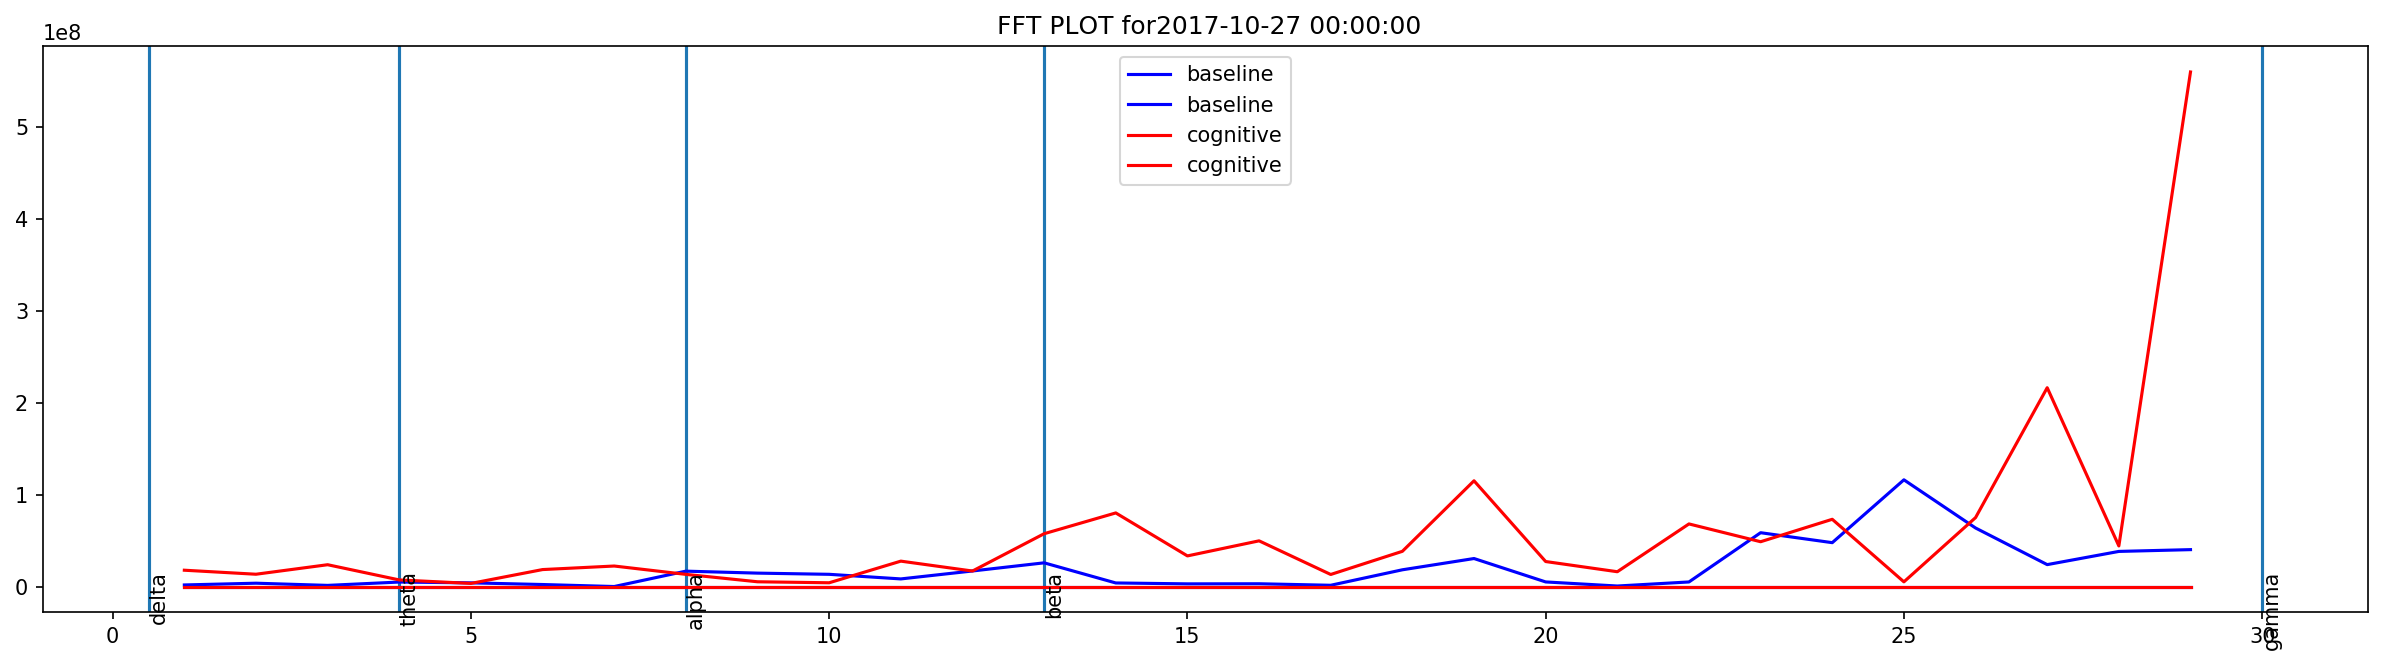

Date 2017-10-28 00:00:00


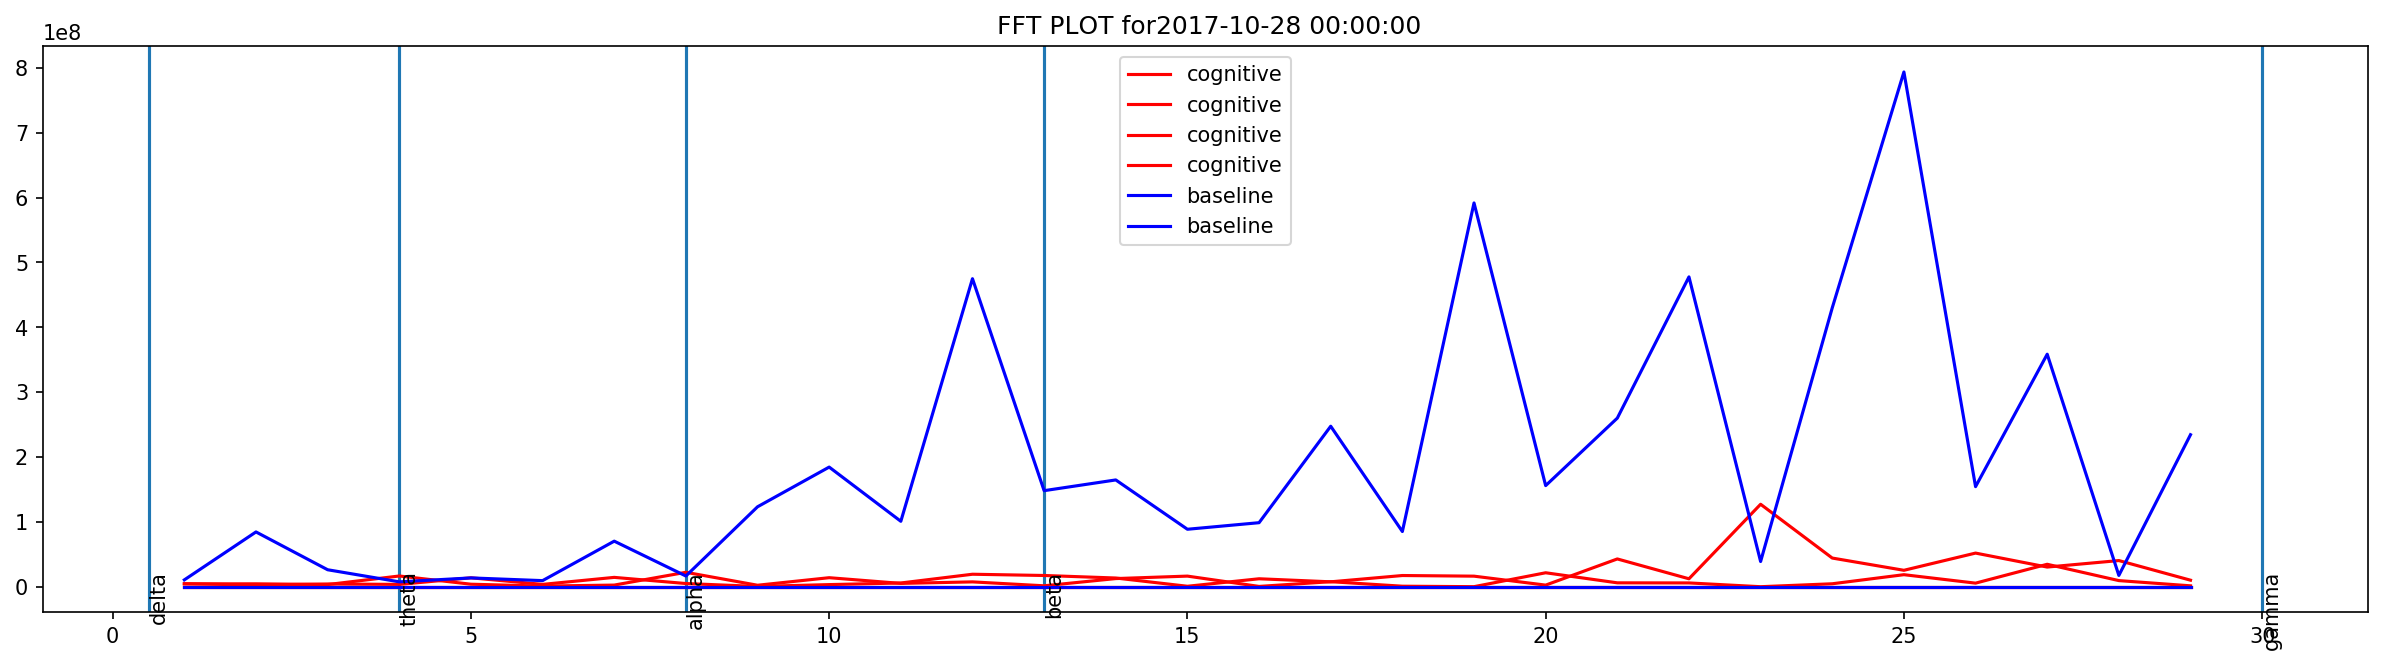

Date 2017-10-29 00:00:00


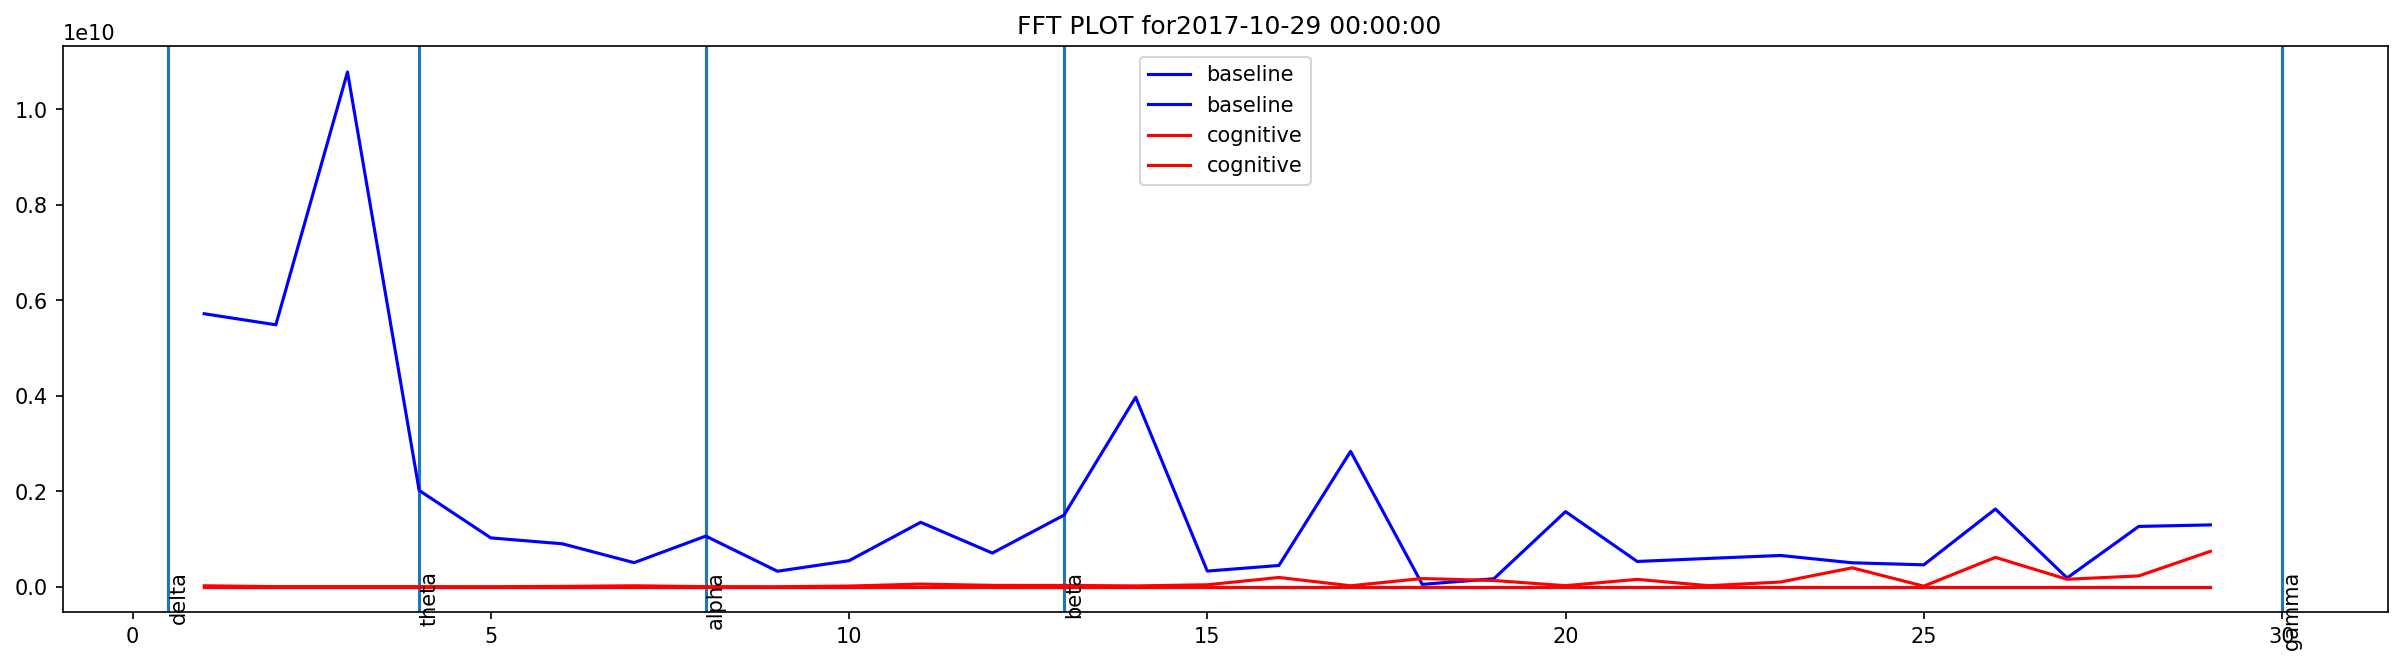

Date 2017-10-30 00:00:00


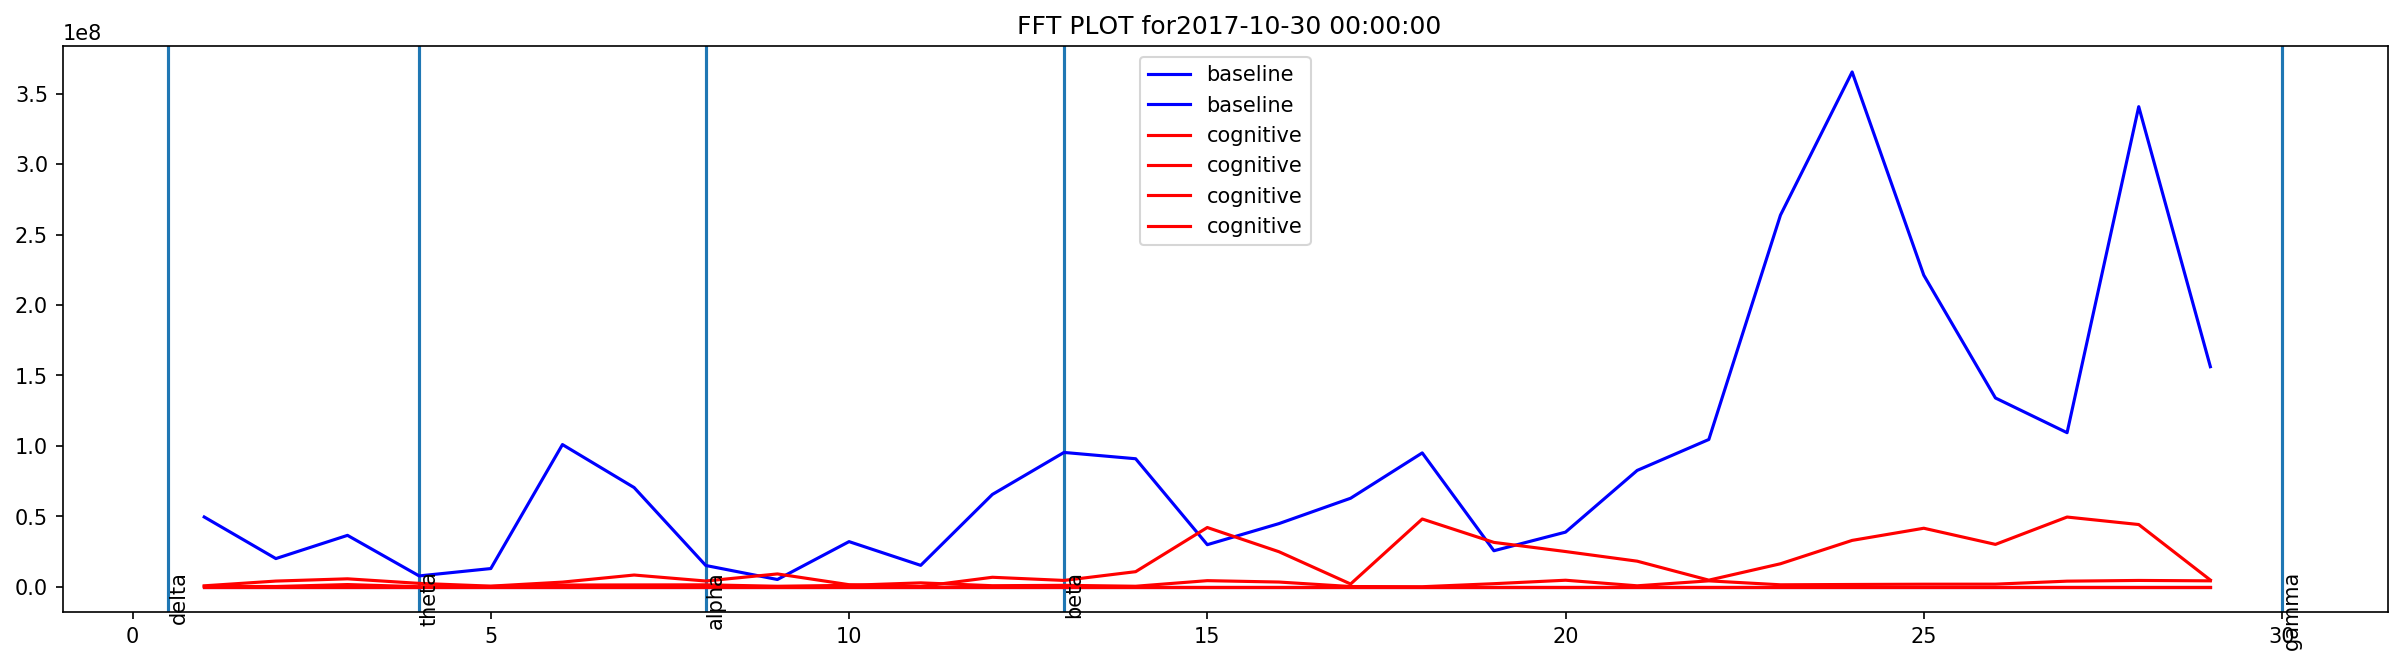

Date 2017-10-31 00:00:00


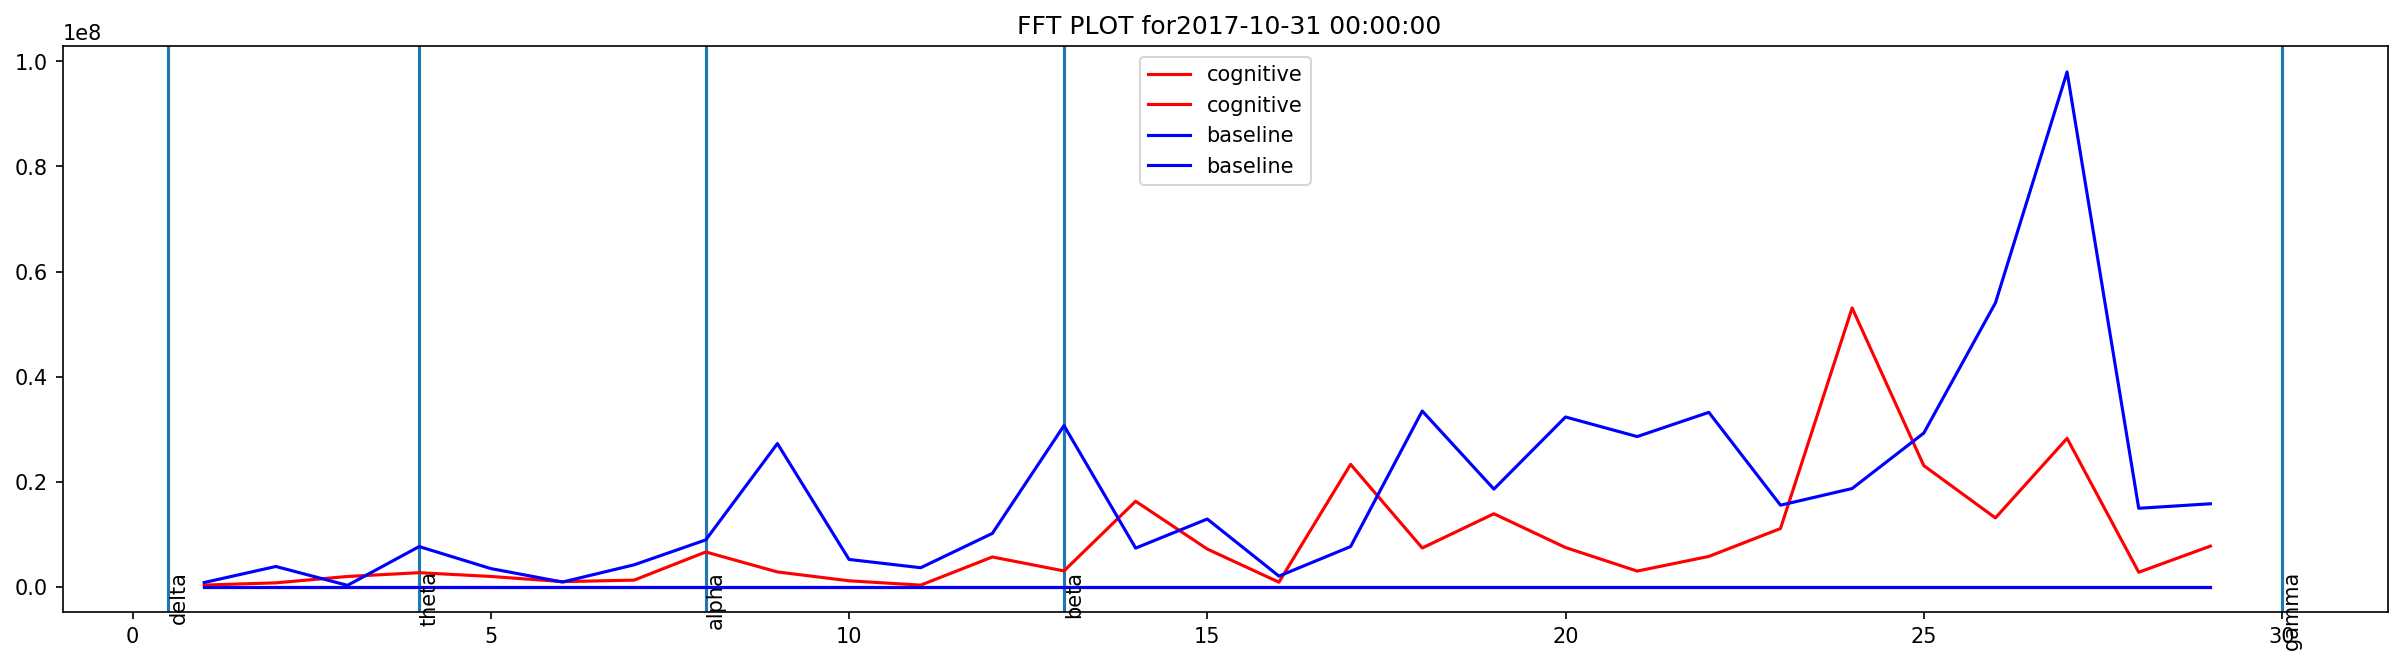

Date 2017-11-02 00:00:00


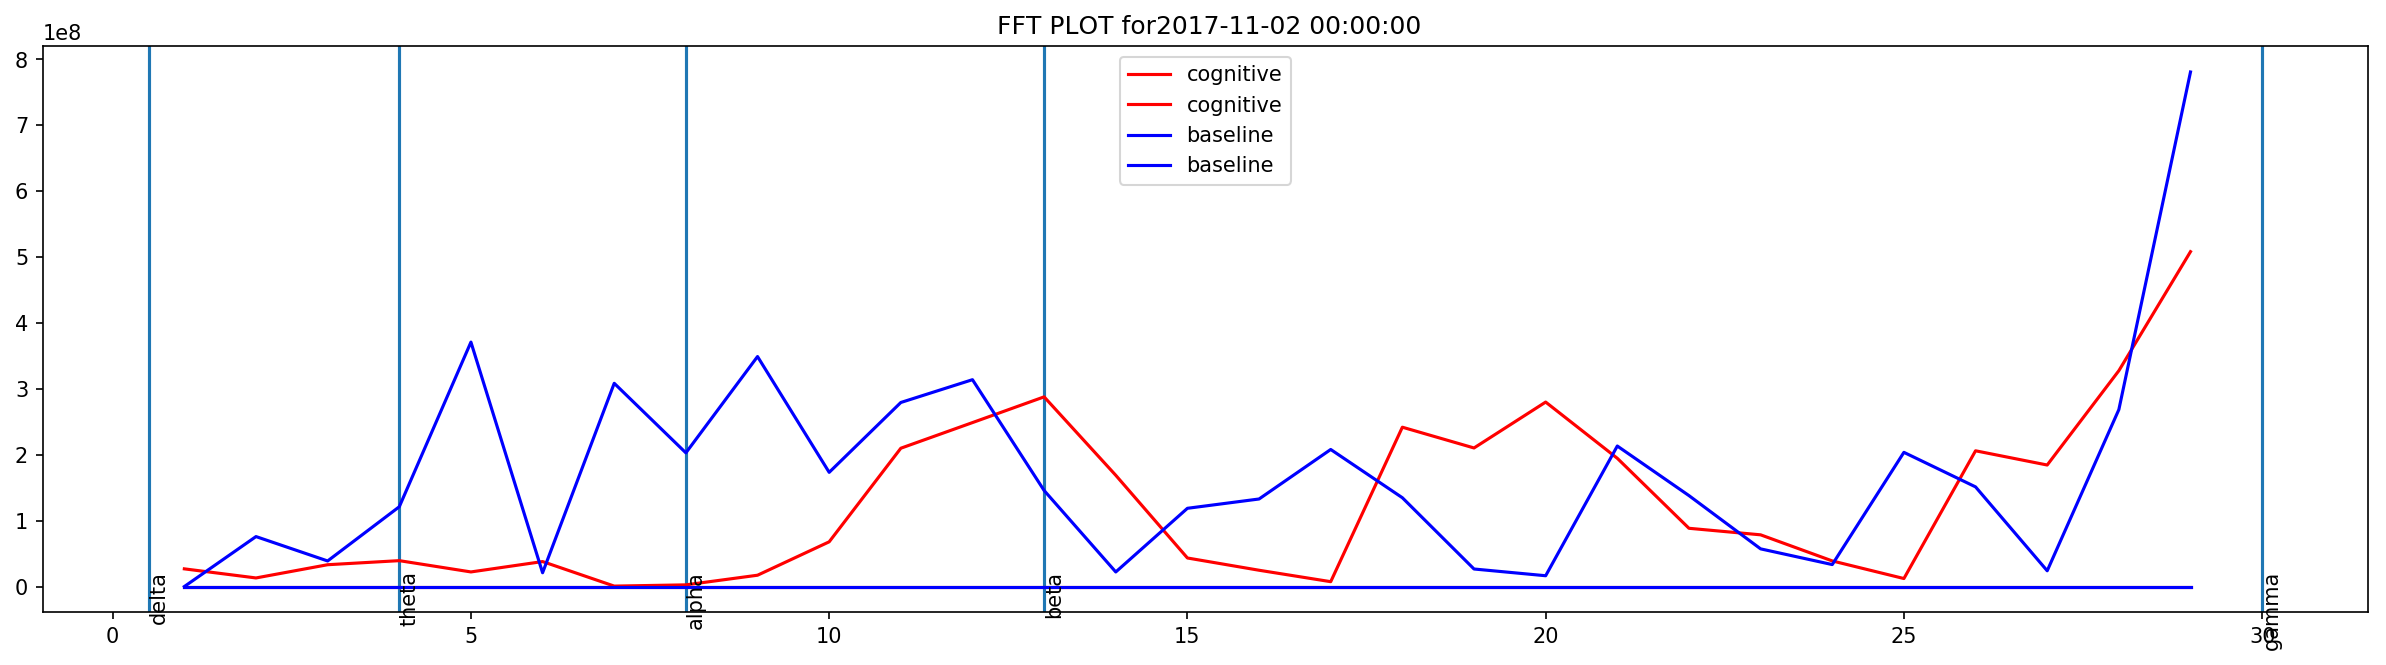

Date 2017-11-06 00:00:00


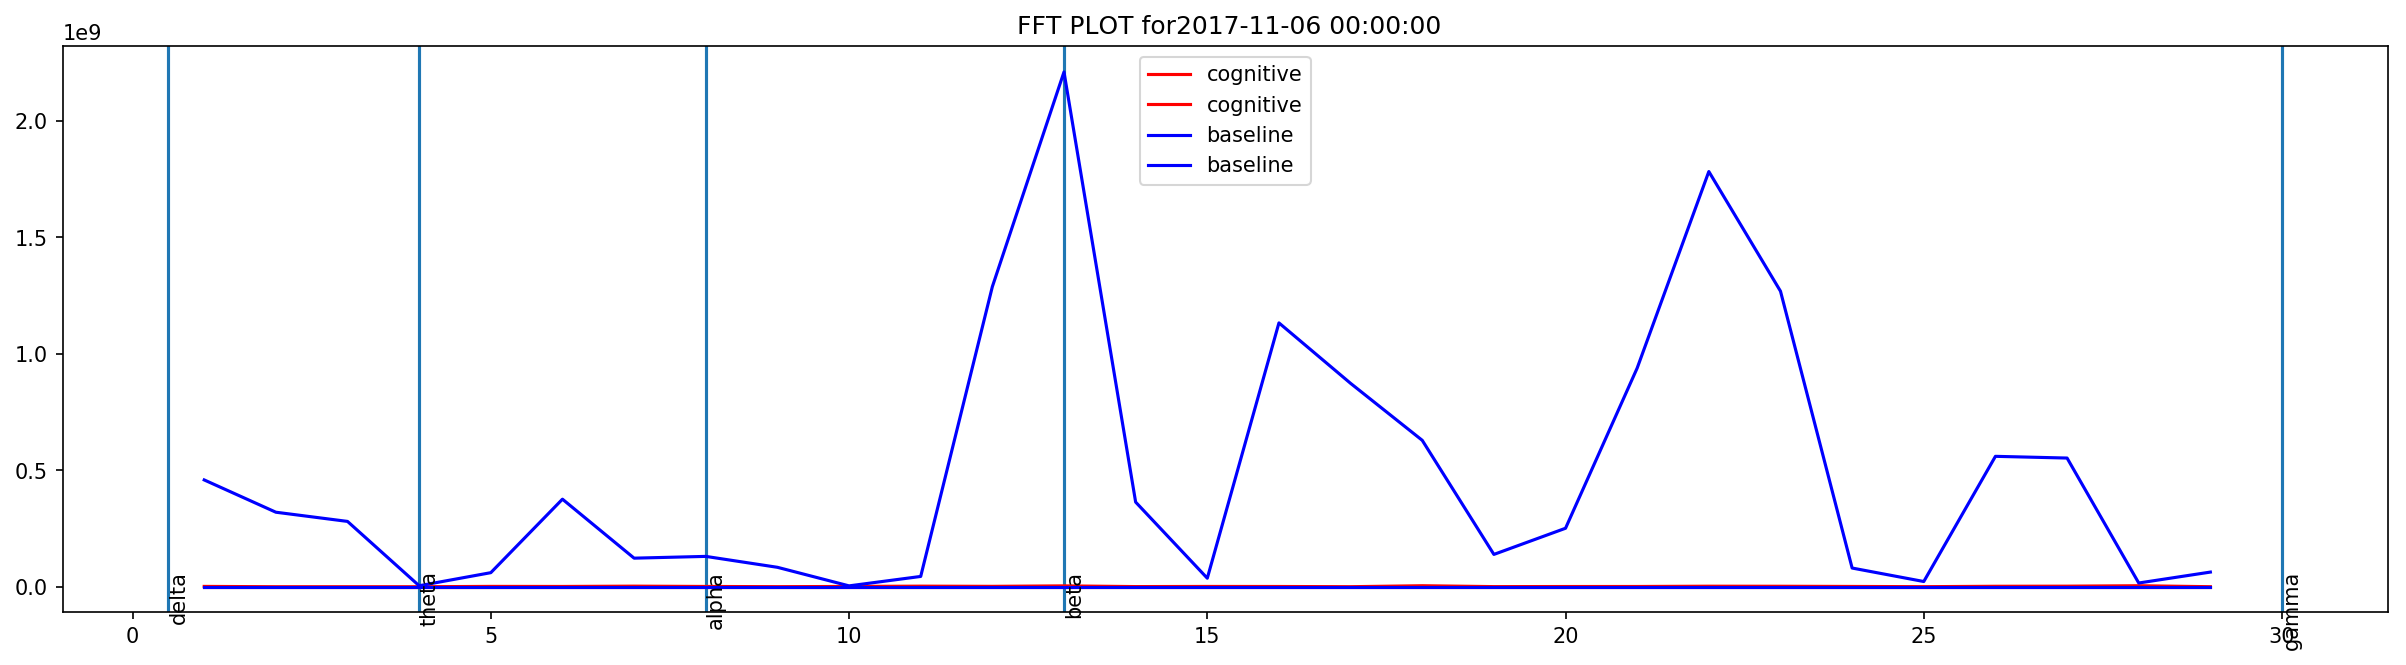

Date 2017-11-07 00:00:00


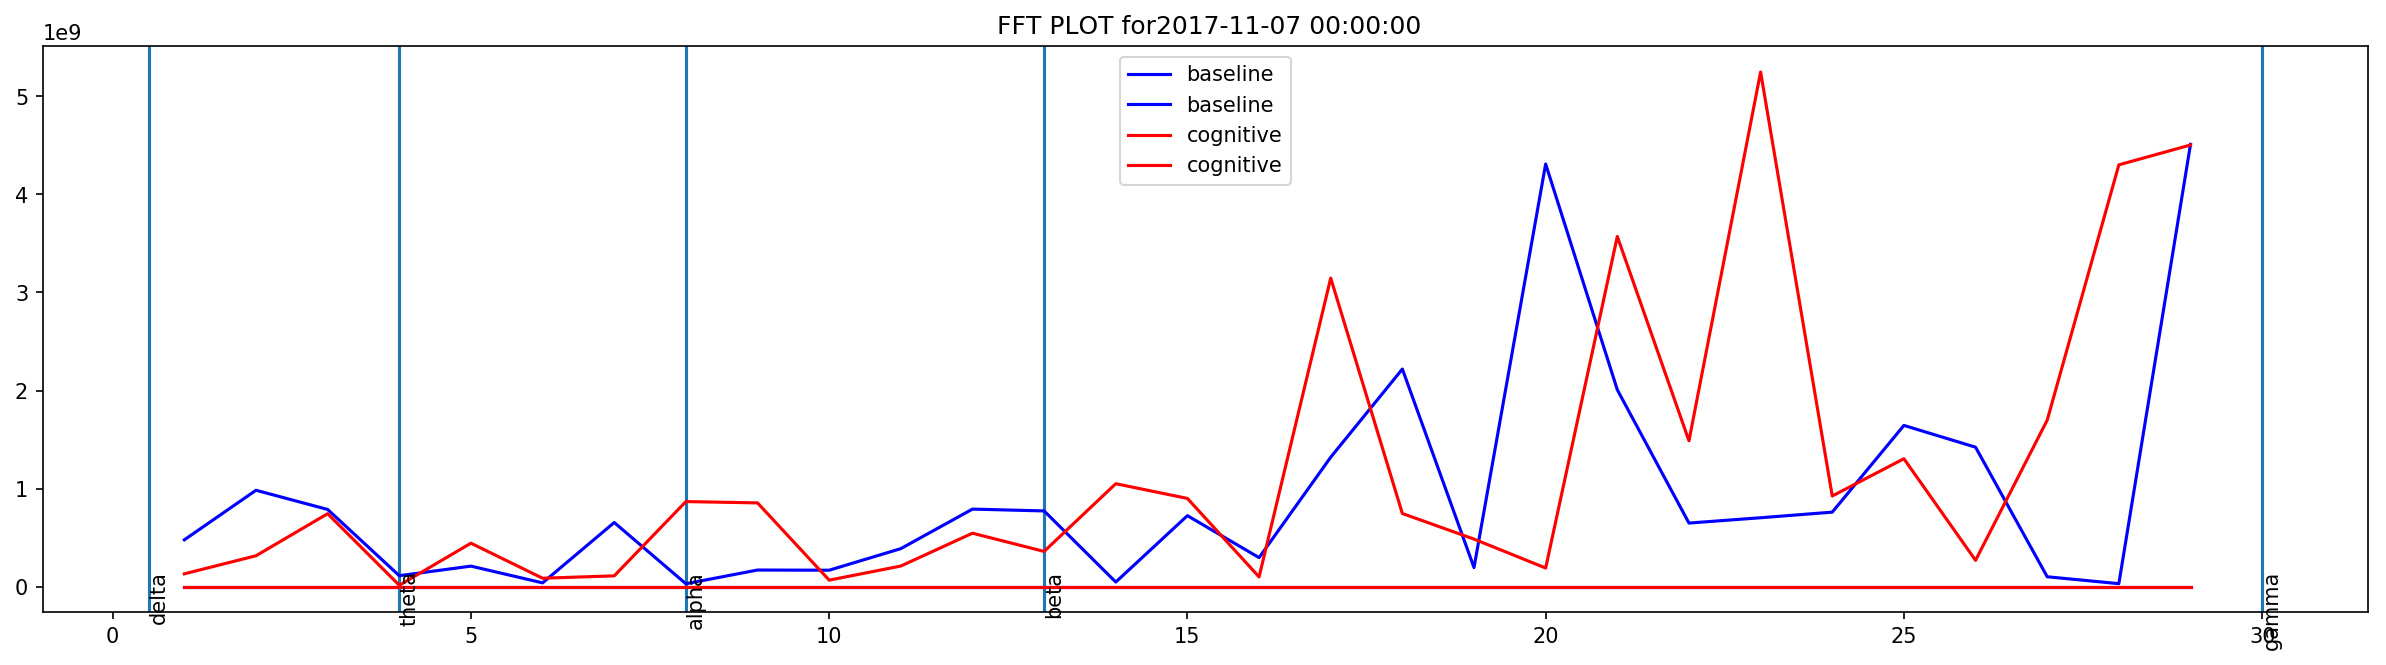

Date 2017-11-10 00:00:00


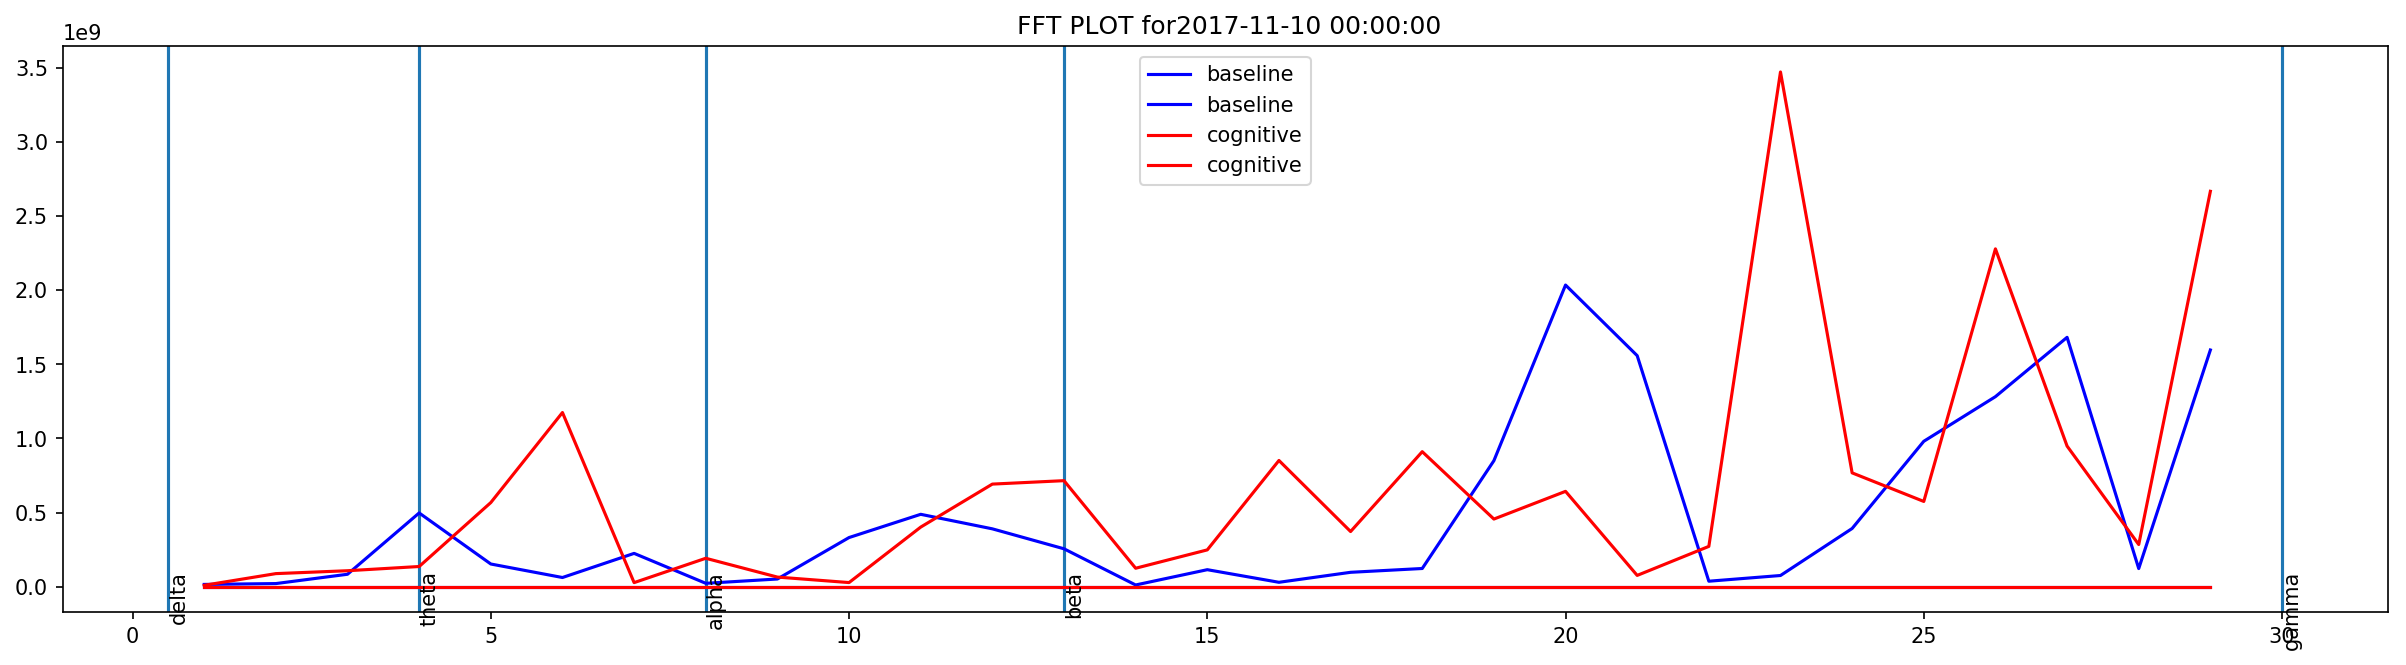

Date 2017-11-12 00:00:00


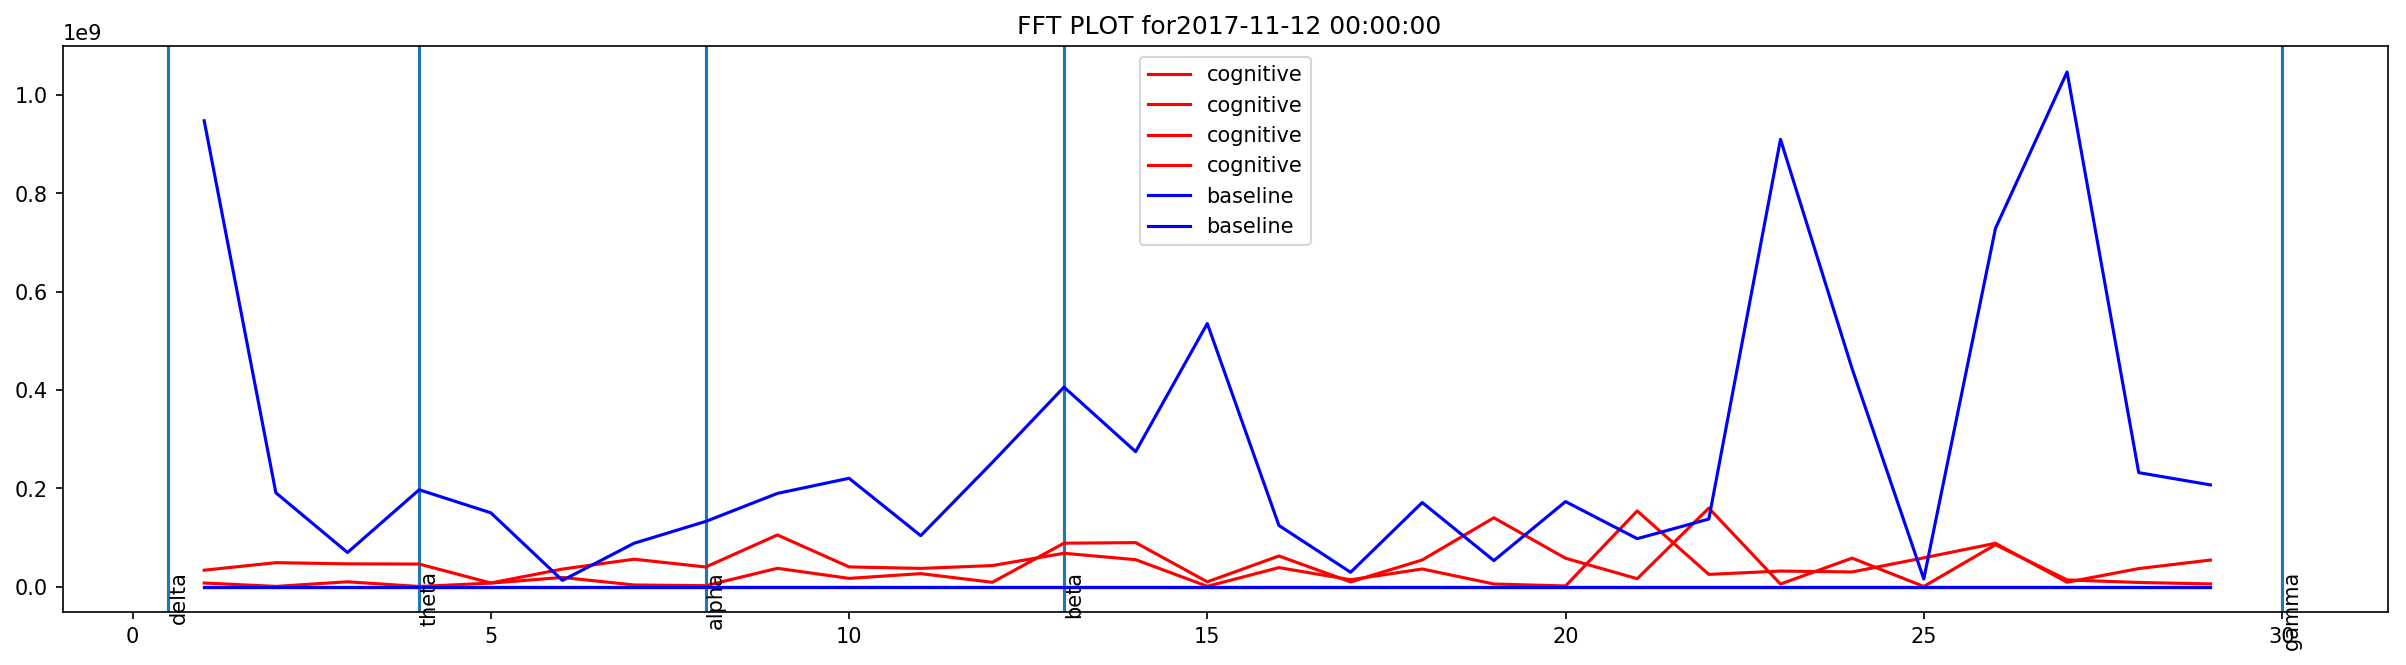

In [108]:
for date, group in dataset.groupby('date'): 
    print('Date', date)
#     print(type(date),type(group),group)
#     plot_eeg(group,date)
    plot_fft_eeg(group,date)


In [71]:
for date, group in dataset.groupby('date'): 
    print('Date', date)
#     print(type(date),type(group),group)


Date 2017-10-08 00:00:00
Date 2017-10-09 00:00:00
Date 2017-10-10 00:00:00
Date 2017-10-11 00:00:00
Date 2017-10-12 00:00:00
Date 2017-10-13 00:00:00
Date 2017-10-16 00:00:00
Date 2017-10-18 00:00:00
Date 2017-10-20 00:00:00
Date 2017-10-22 00:00:00
Date 2017-10-23 00:00:00
Date 2017-10-24 00:00:00
Date 2017-10-27 00:00:00
Date 2017-10-28 00:00:00
Date 2017-10-29 00:00:00
Date 2017-10-30 00:00:00
Date 2017-10-31 00:00:00
Date 2017-11-02 00:00:00
Date 2017-11-06 00:00:00
Date 2017-11-07 00:00:00
Date 2017-11-10 00:00:00
Date 2017-11-12 00:00:00


In [ ]:
s=np.array(sample)
s=s.reshape(len(dataset),500)

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity


cosine_similarity(s[:5,:])

## Let's find the cosine similarity across dates for a particular task

In [93]:
dataset = pd.read_csv('all_data_labelled.csv')
dataset.eeg = dataset.eeg.map(json.loads)
dataset['date']=pd.to_datetime(dataset['date'])

dataset=dataset.sort_values(by='date')
def to_power_spectrum_df(raw_readings):
    '''
    Take raw voltages,
    transform into frequency domain,
    return a power spectrum.
    
    '''
    sampling_rate=len(raw_readings)
    # FFT the raw readings
    fftd = np.fft.fft(raw_readings)
    # take absolute value
    # producing a symmetrical power spectrum
    ps = np.abs(fftd)**2
    # since the power spectrum is symmetrical, 
    # take half
    half_len = len(ps)//2
    ps = ps[:half_len]
#     # we'll calculate the frequencies
    window_size = len(raw_readings)
    freqs = numpy.fft.fftfreq(window_size,d=1/sampling_rate)
#     # splitting that in half to match
    freqs = freqs[:half_len]
    power_spectrum = {
        'frequency (Hz)': freqs,
        'magnitude': ps,
    }
    return power_spectrum['magnitude']

In [76]:
# Here we are selecting 512 points from a random starting point

In [77]:
def pickup_random_sample(raw_reading):
    pick_len =1024 #length of chunk we want to choose
    total_len = len(raw_reading)
    start_pt = np.random.randint(total_len - pick_len)
    segment = raw_reading[start_pt:start_pt+pick_len]
    return to_power_spectrum_df(segment)

In [78]:
# dataset = pd.read_csv('all_data_labelled.csv')
# dataset.eeg = dataset.eeg.map(json.loads)

In [79]:
# lengths_of_eeg=dataset['eeg'].apply(lambda x:len(x))
# # min(lengths_of_eeg)
# rm=[i for i, j in enumerate(lengths_of_eeg) if j == 0]
# dataset=dataset.drop(dataset.index[[rm]])


In [80]:
dataset["segment"] = dataset.eeg.apply(pickup_random_sample)


In [81]:
dataset_baseline = dataset[dataset.task=="baseline"].copy(deep=True)
# all lumosity activities
dataset_cognitive = dataset[dataset.task=="cognitive"].copy(deep=True)

In [82]:
dataset_baseline = dataset_baseline.reset_index(drop=True)
dataset_cognitive = dataset_cognitive.reset_index(drop=True)


In [83]:
def get_cosine_similarity(a,b):
    a = np.array(a)
    b = np.array(b)
    return dot(a,b)/(norm(a)*norm(b))

In [84]:
date_list_baseline = dataset_baseline.date.tolist()
segments_list_baseline = dataset_baseline.segment.tolist()
phase_list_baseline=dataset_baseline.phase_distance.tolist()
phase_baseline=dataset_baseline.phase_no.tolist()

date_list_cognitive = dataset_cognitive.date.tolist()
segments_list_cognitive= dataset_cognitive.segment.tolist()
phase_list_cognitive=dataset_cognitive.phase_distance.tolist()
phase_cognitive=dataset_cognitive.phase_no.tolist()

In [85]:
baseline_comparisons = []
for segment1 in segments_list_baseline:
    curr_list = []
    for segment2 in segments_list_baseline:
        curr_list.append(get_cosine_similarity(segment1,segment2))
    baseline_comparisons.append(np.array(curr_list))
# baseline_comparisons

In [86]:
cognitive_comparisons = []
for segment1 in segments_list_cognitive:
    curr_list = []
    for segment2 in segments_list_cognitive:
        curr_list.append(get_cosine_similarity(segment1,segment2))
    cognitive_comparisons.append(np.array(curr_list))
    
# cognitive_comparisons

In [87]:
baseline_comparisons = np.array(baseline_comparisons)
cognitive_comparisons = np.array(cognitive_comparisons)

In [88]:
def plot_date_similarity(comparisons, date_list, task):
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
#     cax = ax.matshow(comparisons, vmin=-1, vmax=1)
    cax = ax.imshow(comparisons, interpolation="nearest", cmap=cmap)
#     ax.grid(True)
    ticks = numpy.arange(0,len(date_list),1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(date_list,rotation='vertical',fontsize=14)
    ax.set_yticklabels(date_list,fontsize=14)
    plt.title("Cosine Similarity of "+ task+" task across different days",fontsize=18)
    plt.colorbar(cax, ticks=[0,.2,.4,.6,.8,1])
    plt.show()
    
    
    
#         from matplotlib import pyplot as plt
#     from matplotlib import cm as cm

#     fig = plt.figure()
#     ax1 = fig.add_subplot(111)
#     cmap = cm.get_cmap('jet', 30)
#     cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
#     ax1.grid(True)
#     plt.title('Abalone Feature Correlation')
#     labels=['Sex','Length','Diam','Height','Whole','Shucked','Viscera','Shell','Rings',]
#     ax1.set_xticklabels(labels,fontsize=6)
#     ax1.set_yticklabels(labels,fontsize=6)
#     # Add colorbar, make sure to specify tick locations to match desired ticklabels
#     fig.colorbar(cax, ticks=[.75,.8,.85,.90,.95,1])
#     plt.show()

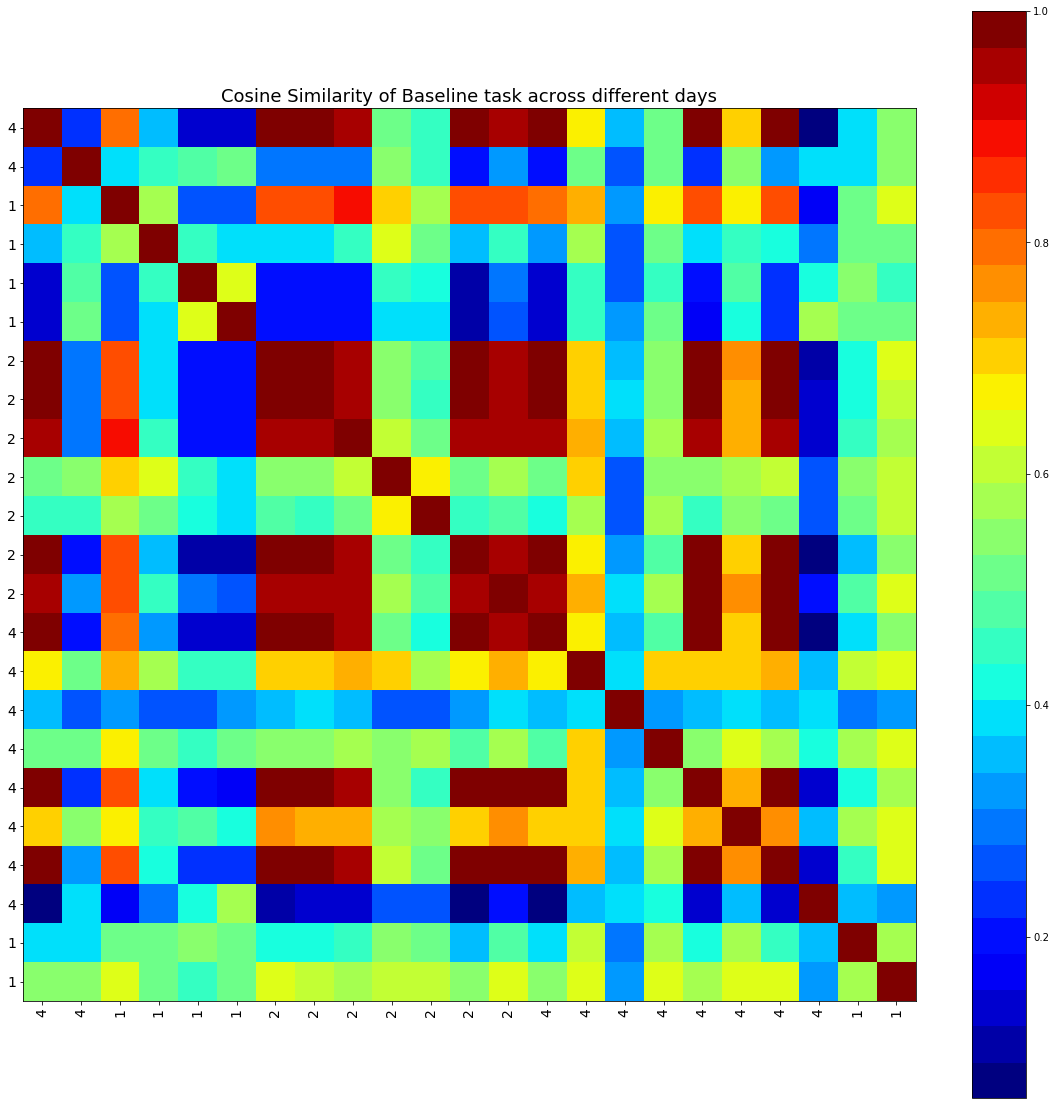

In [91]:
plot_date_similarity(baseline_comparisons, phase_baseline, "Baseline")

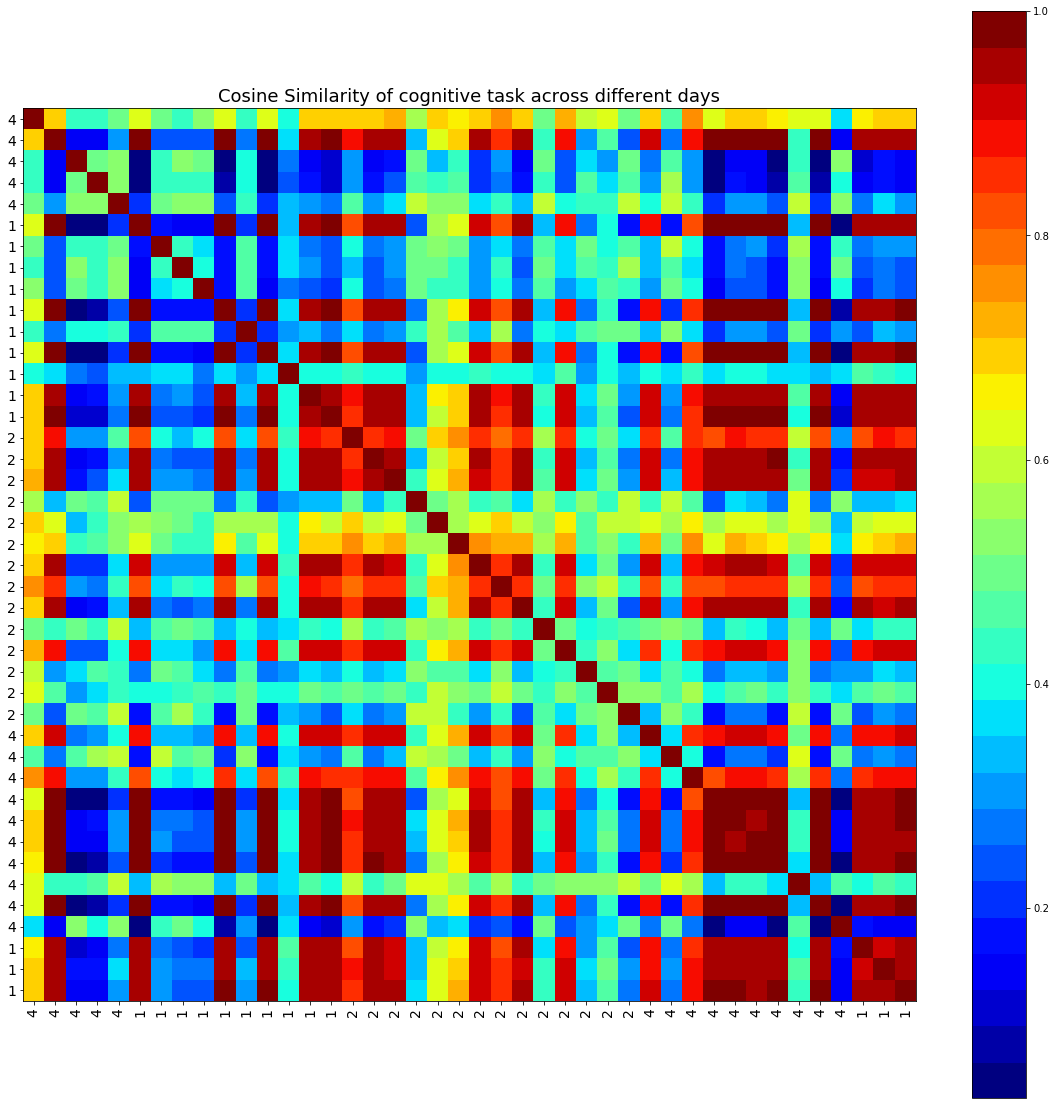

In [92]:
plot_date_similarity(cognitive_comparisons, phase_cognitive, "cognitive")

In [110]:
def plot_date_similarity_lines(comparisons, date_list, task):
    fig = plt.figure(figsize=(18,5))
    ax = fig.add_subplot(111)
    cax = ax.plot(comparisons[0])
    ticks = numpy.arange(0,len(date_list),1)
    ax.set_xticks(ticks)
#     ax.set_yticks(ticks)
    ax.set_xticklabels(date_list)
#     ax.set_yticklabels(date_list)
    plt.title("Cosine Similarity of "+str(date_list[0])+ task+" task across different days")
    plt.show()

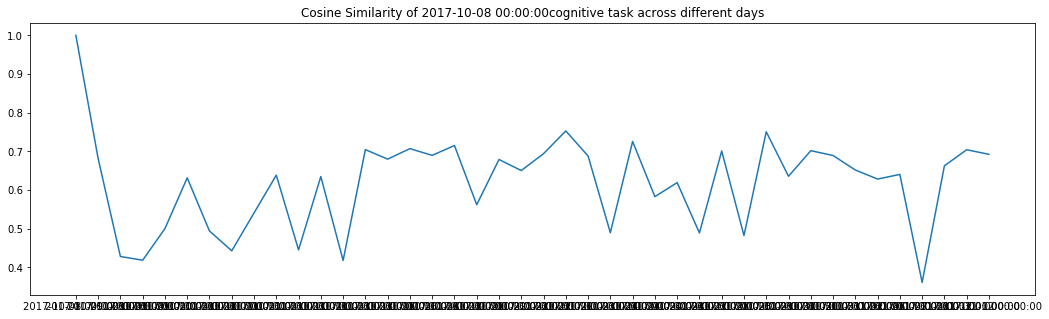

In [111]:
plot_date_similarity_lines(cognitive_comparisons, date_list_cognitive, "cognitive")

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling

from sklearn.metrics import confusion_matrix
# mat = confusion_matrix(digits.target, labels)
date_list=str(date_list_cognitive)
sns.heatmap(cognitive_comparisons, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=date_list,
            yticklabels=date_list)

plt.xlabel('true label')
plt.ylabel('predicted label');

